In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import seaborn as sns
import time
from torchviz import make_dot, make_dot_from_trace
from skimage import io, transform
from torch import tensor
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output
import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility

# Common modules

In [30]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)
    
class UniformNormalize:
    '''Set a uniform threshold accross all samples
    '''
    def __init__(self, noise_floor):
        self.noise_floor = noise_floor
        
    def __call__(self, matrix):
        matrix -= self.noise_floor
        matrix /= (-self.noise_floor/2)
        return matrix.astype(np.float32)
        
class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_image_continuous(pred_batch, pred_ntx, truth_batch, index, grid_len, debug=False):
        '''Continuous -- for single TX
           euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
           now both prediction and truth are continuous numbers
        Args:
            pred_batch:  numpy.ndarray -- size=(N, 1, 100, 100)
            truth_batch: numpy.ndarray -- size=(N, num_tx, 2)
        Return:
            pred_locs -- list<np.ndarray>
            errors    -- list<list>
            misses    -- list
            false     -- list
        '''
        def float_target(pred_matrix, pred_peaks):
            new_pred_peaks = []
            for pred_x, pred_y in pred_peaks:
                sum_weight = 0
                neighbor = []
                for d in [(0, 0), (-1, 0), (0, 1), (1, 0), (0, -1)]:
                    nxt = (pred_x + d[0], pred_y + d[1])
                    if 0 <= nxt[0] < grid_len and 0 <= nxt[1] < grid_len:
                        neighbor.append(((nxt[0] + 0.5, nxt[1] + 0.5), pred[nxt[0]][nxt[1]]))
                        sum_weight += pred_matrix[nxt[0]][nxt[1]]
                pred_x, pred_y = 0, 0
                for n in neighbor:
                    loc = n[0]
                    w   = n[1]
                    pred_x += loc[0] / sum_weight * w
                    pred_y += loc[1] / sum_weight * w
                new_pred_peaks.append((pred_x, pred_y))
            return new_pred_peaks

        pred_locs = []
        errors = []
        misses = []
        falses = []
        for i, pred, pred_n, truth, indx in zip(range(len(pred_batch)), pred_batch, pred_ntx, truth_batch, index):
            # 1: get the multiple predicted locations
            pred = pred[0]           # there is only one channel
            pred_peaks, _ = Utility.detect_peak(pred, np.round(pred_n, 0), 0.1)         # get the predictions  TIME: 23 milliseconds
            pred_peaks = float_target(pred, pred_peaks)
            # 2: do a matching and get the error
            radius_threshold = Default.grid_length * Default.error_threshold
            error, miss, false = Utility.compute_error(pred_peaks, truth, radius_threshold, False)
            errors.append(error)
            misses.append(miss)
            falses.append(false)
            if debug:
                print(i, indx, 'pred', [(round(loc[0], 2), round(loc[1], 2)) for loc in pred_peaks], '; truth', \
                      [(round(loc[0], 2), round(loc[1], 2)) for loc in truth], ' ; error', error, ' ; miss', miss, ' ; false', false)
        return errors, misses, falses

    @staticmethod
    def loss(pred, y):
        n = len(pred) * len(pred[0])
        summ = np.sum((pred - y)**2)
        return summ/n

# 2 Output is image, model as image translation problem

## Output representation is a grid (image)
## Use weighting to get a continuous output prediction

## Data

In [3]:
class SensorInputDatasetTranslation(Dataset):
    '''Sensor reading input dataset -- for multi TX
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        target_name = str(idx%self.sample_per_label) + '.target.npy'
        target_img, target_float = self.get_translation_target(folder, target_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        target_num = np.array([len(target_float)]).astype(np.float32)
        sample = {'matrix':matrix, 'target':target_img, 'target_float':target_float, 'target_num':target_num, 'index':idx}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        targets = glob.glob(os.path.join(folder, '*.target.npy'))
        return len(samples) - len(targets)

    def get_translation_target(self, folder: str, target_name: str):
        '''
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixel with the TX is labeled 1, everywhere else is labeled 0
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            neighbor = []
            sum_weight = 0
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        weight = 1./Utility.distance((nxt[0] + 0.5, nxt[1] + 0.5), target_float)
                        sum_weight += weight
                        neighbor.append((nxt, weight))
            for n, w in neighbor:
                grid[n[0]][n[1]] = w / sum_weight * len(neighbor) * 3  # 2 is for adding weights
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), location.astype(np.float32)


# tf = T.Compose([
#      MinMaxNormalize(),
#      T.ToTensor()
# ])

tf = T.Compose([
     UniformNormalize(Default.noise_floor),                 # TUNE: Uniform normalization is better than the above minmax normalization
     T.ToTensor()
])

# training
i = 1
root_dir = './data/matrix-train40'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3)
print('matrix shape:', sensor_input_dataset[i]['matrix'].shape)
print('matrix shape:', sensor_input_dataset[i]['matrix'])
print('target:', sensor_input_dataset[i]['target'])
print('target float:', sensor_input_dataset[i]['target_float'])
print('length:', sensor_input_dataset.__len__())

print('---\n')
# testing
root_dir = './data/matrix-test40'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3)
print('matrix type:', sensor_input_test_dataset[i]['matrix'].dtype)
print('target type:', sensor_input_test_dataset[i]['target'].dtype)
print('target float:', sensor_input_test_dataset[i]['target_float'])
print('target num shape:', sensor_input_test_dataset[i]['target_num'].shape)
print(sensor_input_test_dataset.__len__())

matrix shape: torch.Size([1, 100, 100])
matrix shape: tensor([[[0.0000, 1.3731, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
target: [[[6.622283  1.6017776 0.        ... 0.        0.        0.       ]
  [2.4134004 1.3625389 0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]]
target float: [[ 0.7523271  0.3895659]
 [ 7.3761845 57.87216  ]]
length: 100000
---

matrix type: torch.float32
targ

In [4]:
print(sensor_input_dataset[0]['target_float'])
print(sensor_input_dataset[0]['target'][0][46:51, 62:67])

[[ 0.7523271  0.3895659]
 [21.99486   89.993996 ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


## Model

In [7]:
class NetTranslation2(nn.Module):
    '''Image translation. comparing to NetTranslation, this model is composed of TWO CNNs
       the first CNN is the same as NetTranslation, the second one uses the output of the first CNN and output the # of TX
       this # of TX will help the peak finding and hope reduce the localization error and cardinality error.
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation2, self).__init__()
        self.conv11 = nn.Conv2d(1, 8,  7, padding=3)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv12 = nn.Conv2d(8, 32, 7, padding=3)
        self.conv13 = nn.Conv2d(32, 1, 7, padding=3)
        self.conv21 = nn.Conv2d(1, 2, 5)
        self.conv22 = nn.Conv2d(2, 4, 5)
        self.conv23 = nn.Conv2d(4, 8, 5)
        self.groupnorm1 = nn.GroupNorm(1, 2)
        self.groupnorm2 = nn.GroupNorm(2, 4)
        self.groupnorm3 = nn.GroupNorm(4, 8)
        self.fc1 = nn.Linear(648, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # first CNN input is 1 x 100 x 100
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        y1 = self.conv13(x)
        # second CNN takes in y1, which is also 1 x 100 x 100
        x = F.max_pool2d(F.relu(self.groupnorm1(self.conv21(y1))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm2(self.conv22(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm3(self.conv23(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        y2 = self.fc2(x)
        return y1, y2

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = NetTranslation2()
print(net)

NetTranslation2(
  (conv11): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv12): Conv2d(8, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv13): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv21): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv22): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv23): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (groupnorm1): GroupNorm(1, 2, eps=1e-05, affine=True)
  (groupnorm2): GroupNorm(2, 4, eps=1e-05, affine=True)
  (groupnorm3): GroupNorm(4, 8, eps=1e-05, affine=True)
  (fc1): Linear(in_features=648, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


## Loss is nn.MSELoss()

In [5]:
def make_zeros(batch=32, length=100):
    zeros = []
    for _ in range(batch):
        zero = np.zeros((length, length))
        zero = np.expand_dims(zero, 0)
        zeros.append(zero)
    return torch.as_tensor(zeros).to(torch.device('cuda'))


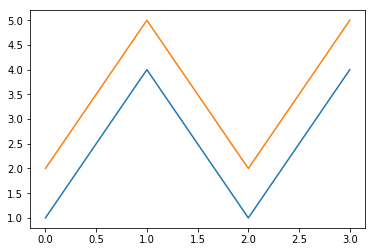

In [38]:
a = [1,2]
b = [4,5]
c = [1,2]
d = [4,5]
e = [a, b]
f = [c, d]
f.extend(e)

plt.plot(f)

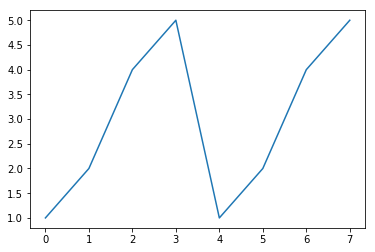

In [46]:
plt.plot([val for sublist in f for val in sublist])

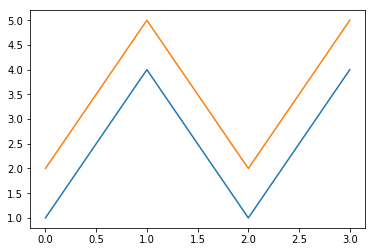

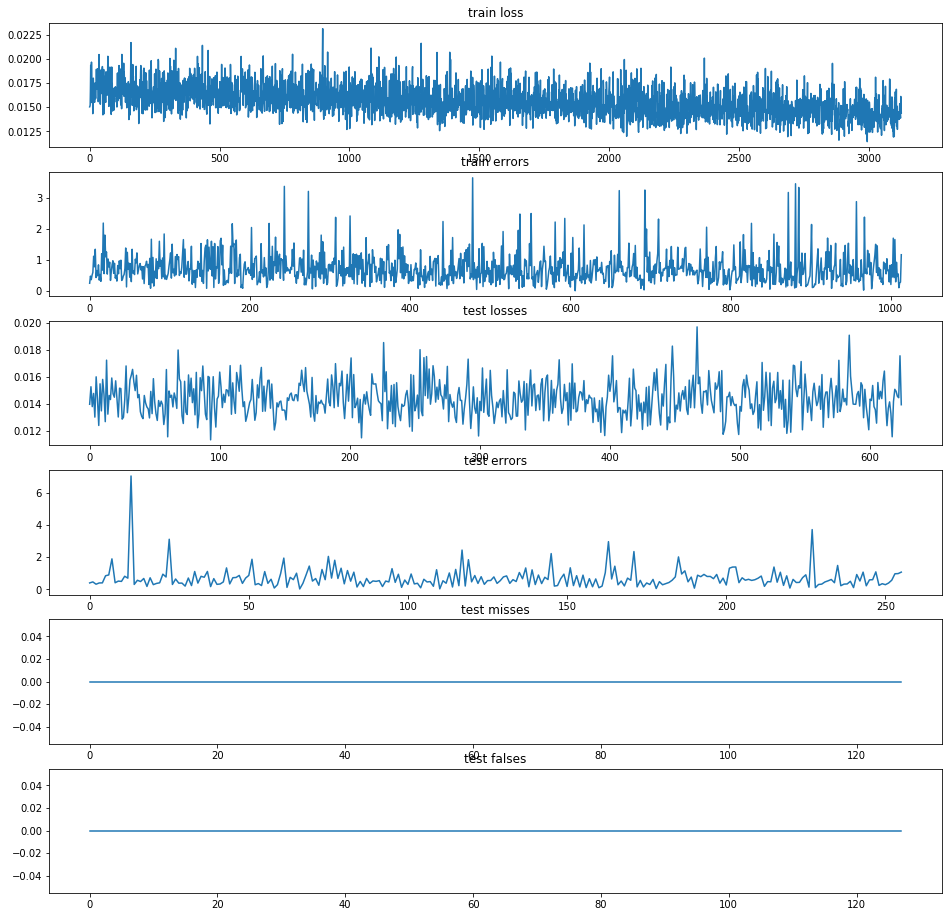

train loss mean = 0.015644624941945077
train loss std  = 0.0015636130564045522
test  loss mean = 0.014410007683932781
test  loss std  = 0.0013110012333687501
train error mean = 0.7383301775147929
train error std  = 0.4985193260628457
test  error mean = 0.697290234375
test  error std  = 0.6512452643349471
test misses mean =  0.0
test misses std =  0.0
test falses mean =  0.0
test falses std =  0.0
train loss
(0.024556218396425248, 0.09765007441002757)
(0.015644624941945077, 0.0015636130564045522)
train error
(1.876610737527115, 1.6473045584368913)
(0.7383301775147929, 0.4985193260628457)
test loss
(0.016734658357501028, 0.001378937958924913)
(0.014410007683932781, 0.0013110012333687501)
test error
(0.8318373015873015, 0.5590274526487414)
(0.697290234375, 0.6512452643349471)
test misses
(0.03125, 0.17399263633843817)
(0.0, 0.0)
test falses
(0.0234375, 0.15128841196122722)
(0.0, 0.0)


In [50]:
# %%time
# image translation problem

net = NetTranslation2()

device    = torch.device('cuda')
model     = net.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion1 = nn.MSELoss()  # criterion is the loss function
criterion2 = nn.MSELoss()   # latter change this to MSELoss and see what happens
criterion3 = nn.L1Loss()

num_epochs = 2
train_losses_epoch = []
train_errors_epoch = []
test_losses_epoch  = []
test_errors_epoch  = []
test_misses_epoch = []
test_falses_epoch = []
print_every = 500
error_every = 200
# zeros = make_zeros(batch=32, length=100)
alpha = 0

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses = []
    train_errors = []
    test_losses  = []
    test_errors  = []
    test_misses  = []
    test_falses  = []
    model.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_float = np.array(sample['target_float'])
        indx = sample['index']
        pred_matrix, pred_ntx = model(X)              # the model
        loss_matrix = criterion1(pred_matrix, y)
        loss_num_tx = criterion2(pred_ntx, y_num)
        regulation  = criterion3(pred_matrix, zeros)
        loss = loss_matrix + loss_num_tx + regulation*alpha
#         loss = loss_matrix + loss_num_tx
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        pred_ntx = pred_ntx.data.cpu().numpy()
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length)
            train_errors.extend(errors)
        if t % print_every == 0:
            print(f't = {t}, loss_matrix = {loss_matrix.item()}, loss_num_tx = {loss_num_tx.item()}, regulation = {regulation.item()}')

    model.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_float = np.array(sample['target_float'])
        indx = sample['index']
        pred_matrix, pred_ntx = model(X)               # the model
        loss_matrix = criterion1(pred_matrix, y)
        loss_num_tx = criterion2(pred_ntx, y_num)
        loss = loss_matrix + loss_num_tx
        test_losses.append(loss.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        pred_ntx = pred_ntx.data.cpu().numpy()
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length)
            test_errors.extend(errors)
            test_misses.extend(misses)
            test_falses.extend(falses)
    clear_output(True)
    plt.figure(figsize=(16, 16))
    plt.subplot(611)
    plt.title('train loss')
    plt.plot(train_losses)
    plt.subplot(612)
    plt.title('train errors')
    train_errors = [val for sublist in train_errors for val in sublist]  # flatten a 2D matrix
    plt.plot(train_errors)
    plt.subplot(613)
    plt.title('test losses')
    plt.plot(test_losses)
    plt.subplot(614)
    plt.title('test errors')
    test_errors = [val for sublist in test_errors for val in sublist]
    plt.plot(test_errors)
    plt.subplot(615)
    plt.title('test misses')
    plt.plot(test_misses)
    plt.subplot(616)
    plt.title('test falses')
    plt.plot(test_falses)
    plt.show()
    
    print('train loss mean =', np.mean(train_losses))
    print('train loss std  =', np.std(train_losses))
    print('test  loss mean =', np.mean(test_losses))
    print('test  loss std  =', np.std(test_losses))
    print('train error mean =', np.mean(train_errors))
    print('train error std  =', np.std(train_errors))    
    print('test  error mean =', np.mean(test_errors))
    print('test  error std  =', np.std(test_errors))
    print('test misses mean = ', np.mean(test_misses))
    print('test misses std = ',  np.std(test_misses))
    print('test falses mean = ', np.mean(test_falses))
    print('test falses std = ',  np.std(test_falses))
    train_losses_epoch.append((np.mean(train_losses), np.std(train_losses)))
    train_errors_epoch.append((np.mean(train_errors), np.std(train_errors)))
    test_losses_epoch.append((np.mean(test_losses), np.std(test_losses)))
    test_errors_epoch.append((np.mean(test_errors), np.std(test_errors)))
    test_misses_epoch.append((np.mean(test_misses), np.std(test_misses)))
    test_falses_epoch.append((np.mean(test_falses), np.std(test_falses)))

print('train loss')
for loss in train_losses_epoch:
    print(loss)
print('train error')
for error in train_errors_epoch:
    print(error)
print('test loss')
for loss in test_losses_epoch:
    print(loss)
print('test error')
for error in test_errors_epoch:
    print(error)
print('test misses')
for miss in test_misses_epoch:
    print(miss)
print('test falses')
for false in test_falses_epoch:
    print(false)

In [58]:
# evaluation for all test samples
test_errors = []
test_misses = []
test_falses = []
test_index  = []

model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    if t % 10 == 9:
        print(t, end=' ')
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num   = sample['target_num'].to(device)
    y_float = np.array(sample['target_float'])
    indx = sample['index']
    pred_matrix, pred_ntx = model(X)               # the model: 1.1 millisecond
    loss_matrix = criterion1(pred_matrix, y)
    loss_num_tx = criterion2(pred_ntx, y_num)
    loss = loss_matrix + loss_num_tx
    test_losses.append(loss.item())
    pred_matrix = pred_matrix.data.cpu().numpy()
    pred_ntx = pred_ntx.data.cpu().numpy()
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length)  # 0.75 seconds
    test_errors.extend(errors)
    test_misses.extend(misses)
    test_falses.extend(falses)
    test_index.extend(indx.numpy())
    
print()

print('error', np.mean([val for sublist in test_errors for val in sublist]), np.std(test_errors))
print('miss ', np.mean(test_misses), np.std(test_misses))
print('false', np.mean(test_falses), np.std(test_falses))


error 0.6163515625 0.42199777472465255
miss  0.0 0.0
false 0.0 0.0


In [64]:
for indx, errors, miss, false in zip(test_index, test_errors, test_misses, test_falses):
    if max(errors) > 1 or miss > 0 or false > 0:
        print(indx, errors, miss, false)
#     print(indx, error, miss, false)

3358 [0.2172, 1.1905] 0 0
15213 [0.5873, 1.9615] 0 0
14410 [0.9588, 1.0712] 0 0
16991 [0.872, 1.7264] 0 0
13480 [0.3462, 1.0637] 0 0
8555 [0.7667, 2.1363] 0 0
12739 [0.5612, 1.7696] 0 0
10048 [0.4216, 1.1283] 0 0
12626 [0.9183, 1.0279] 0 0


In [138]:
# folder = '2TX-20-min-dist-uniformnorm'
# np.savetxt(f'result/{folder}/train_loss.txt', train_losses_epoch)
# np.savetxt(f'result/{folder}/train_errors.txt', train_losses_epoch)
# np.savetxt(f'result/{folder}/test_loss.txt', test_losses_epoch)
# np.savetxt(f'result/{folder}/test_errors.txt', test_errors_epoch)
# np.savetxt(f'result/{folder}/test_misses.txt', test_misses_epoch)
# np.savetxt(f'result/{folder}/test_falses.txt', test_falses_epoch)

In [13]:
def myplot(X, pred, pred_n, y, indx, i):
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    sns.heatmap(X[0], cmap='gray', annot=False, ax=axs[0])
    sns.heatmap(pred[0], cmap='gray', annot=False, ax=axs[1])
    sns.heatmap(y[0], cmap='gray', annot=False, ax=axs[2])
    axs[0].set_title(f'{indx} - {i}')
    axs[1].set_title(f'# of predict TX {pred_n[0]:.2f}')
    fig.tight_layout()

def myplot2(pred, y, y_float):
    '''
    Args:
        pred    -- array like -- 2d dimension pred matrix
        y       -- array like -- 2d dimension true matrix
        y_float -- array like -- (2, 2), first 2 is the number of TX, second 2 means a pair of (x, y)
    '''
    print(y_float)
    fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'pred {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(pred[a1:a2,b1:b2], cmap='gray', annot=True, ax=axs[i])
        axs[i].set_title(f'pred {i} ({a}, {b})')
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'y    {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(y[a1:a2, b1:b2], cmap='gray', annot=True, ax=axs[i+2])
        axs[i+2].set_title(f'y   {i} ({a}, {b})')
    fig.tight_layout()

loss matrix = 0.013761991634964943
loss num tx = 1.5307256262531155e-07
0 6759 pred [(33.49, 79.45), (74.51, 55.4)] ; truth [(33.39, 79.61), (75.01, 55.5)]  ; error [0.1877, 0.5068]  ; miss 0  ; false 0
[[33.385937 79.60651 ]
 [75.00739  55.49546 ]]
pred 0 (28, 38), (74, 84)
pred 1 (70, 80), (50, 60)
y    0 (28, 38), (74, 84)
y    1 (70, 80), (50, 60)
mean of top left 25 0.18461014


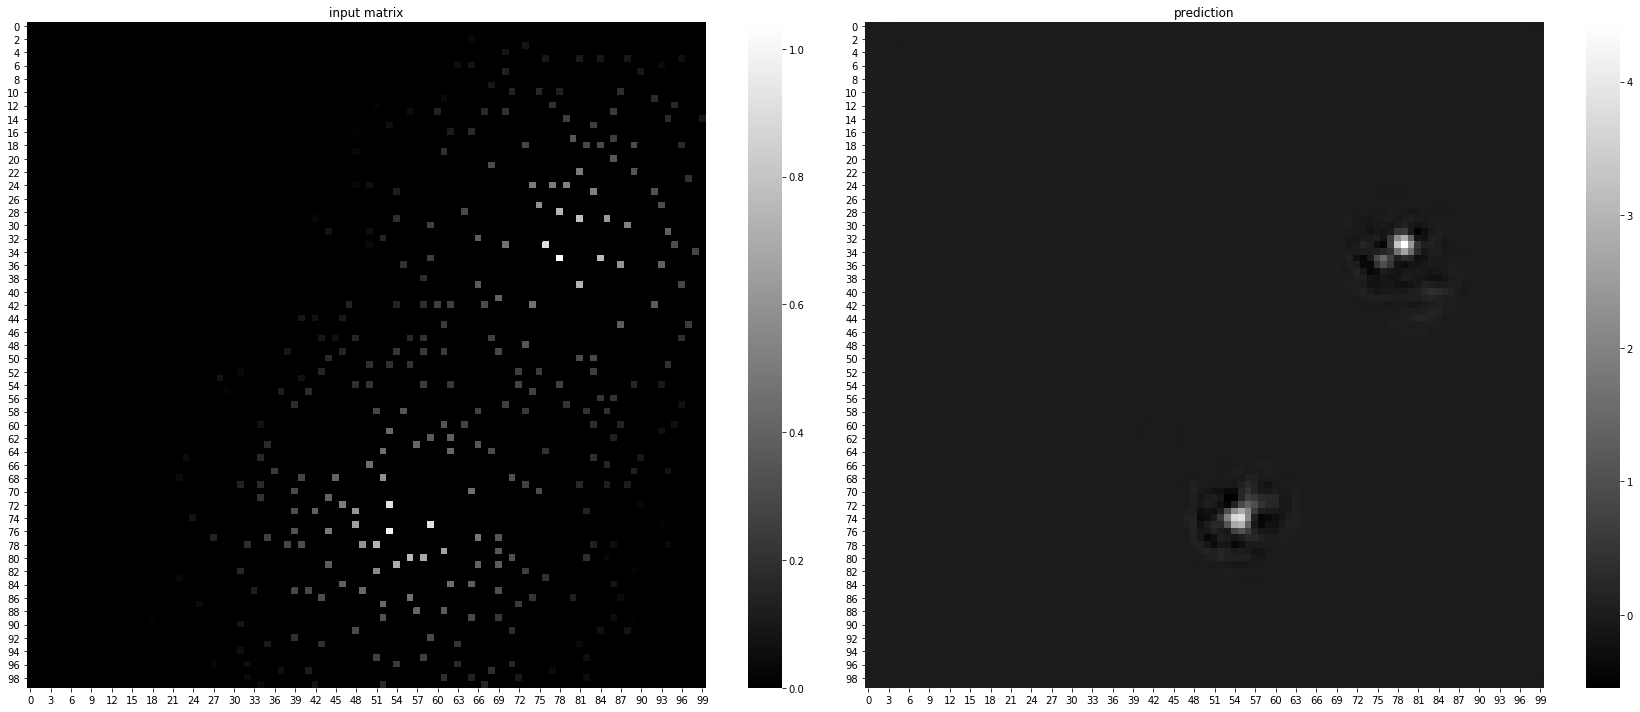

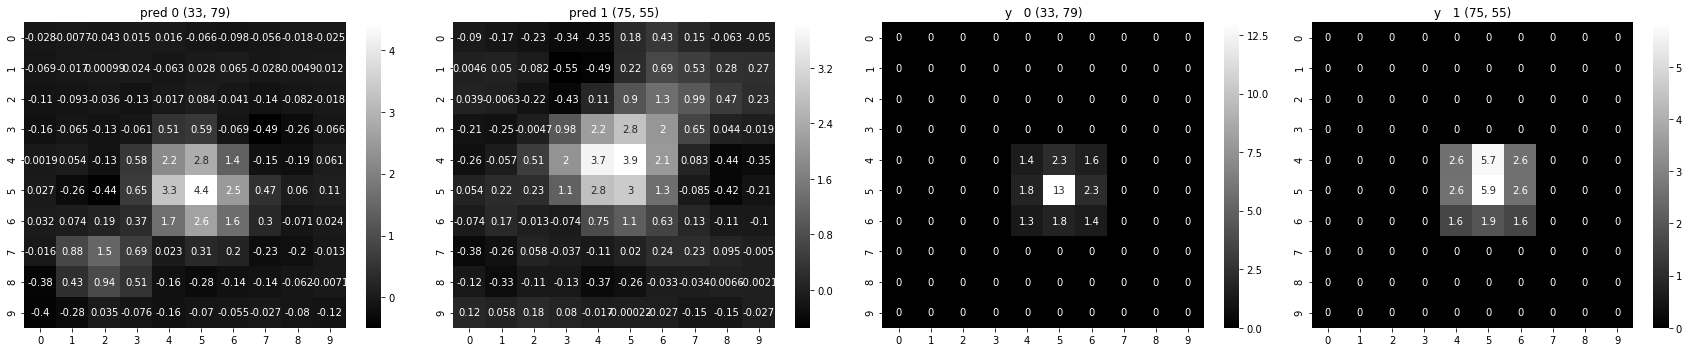

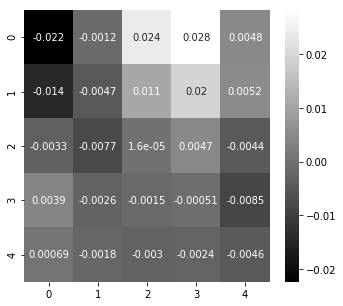

In [21]:
# Test for one sample

# idx = 10318
# idx = 18485
# idx = 12630
# idx = 8373
# idx = 1050
# idx = 5926
# idx = 11592
# idx = 8454
# idx = 10244
# idx = 12174
# idx = 11924
# idx = 11190
idx = 6759

def one_sample(idx):
    device = torch.device('cuda')
    model.eval()
    sample = sensor_input_test_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)

    pred_matrix, pred_ntx = model(X)

    loss_matrix = criterion1(pred_matrix, y)
    loss_num_tx = criterion2(pred_ntx, y_num)
    print('loss matrix =', loss_matrix.item())
    print('loss num tx =', loss_num_tx.item())

    pred_matrix = pred_matrix.data.cpu().numpy()
    pred_ntx    = pred_ntx.data.cpu().numpy()
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix.copy(), pred_ntx, y_f, indx, Default.grid_length, debug=True)

    pred_matrix = pred_matrix[0][0]
    fig, axs = plt.subplots(1, 2, figsize=(24, 10))
    X = X[0][0].data.cpu().numpy()
    sns.heatmap(X, cmap='gray', ax=axs[0])
    axs[0].set_title('input matrix')
    sns.heatmap(pred_matrix, cmap='gray', ax=axs[1])
    axs[1].set_title('prediction')
    plt.tight_layout()
    np.savetxt('test.txt', pred_matrix)
    y = y.data.cpu().numpy()[0][0]
    y_f = y_f[0]
    myplot2(pred_matrix, y, y_f)
    
    fig, ax = plt.subplots(figsize=(5.5, 5))
    sns.heatmap(pred_matrix[:5, :5], cmap='gray', ax=ax, annot=True)
    print('mean of top left 25', np.sum(np.abs(pred_matrix[:5, :5])))

one_sample(idx)

In [14]:
# Test for one random batch

criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()

model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num = sample['target_num'].to(device)
    y_f = np.array(sample['target_float'])
    indx = np.array(sample['index'])
    pred_matrix, pred_num = model(X)
    
    loss_matrix = criterion1(pred_matrix, y)
    loss_num    = criterion2(pred_num, y_num)*100
    print('loss matrix =', loss_matrix.item())
    print('loss num    =', loss_num.item())
    
    losses = []
    for i, pred, yy in zip(range(len(y)), pred_matrix, y):
        pred, yy = pred[0].data.cpu().numpy(), yy[0].data.cpu().numpy()
        loss = Metrics.loss(pred, yy)
        losses.append((i, loss))
    losses.sort(key=lambda x:x[1])
    for idx, (i, loss) in enumerate(losses):
        print('{}: matrix loss = {}'.format(i, loss), end='   ')
        if idx % 4 == 3: 
            print()
    print()
    pred_matrix = pred_matrix.data.cpu().numpy()   # not using .numpy() will cause big issue
    pred_num = pred_num.data.cpu().numpy()
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_num, y_f, indx, Default.grid_length, True)
    print('error', np.mean(errors), np.std(errors))
    print('miss ', np.mean(misses), np.std(misses))
    print('false', np.mean(falses), np.std(misses))
    break

X    = X.data.cpu().numpy()
# pred_matrix = pred_matrix.data.cpu().numpy()
# pred_ntx = pred_ntx.data.cpu().numpy()
y    = y.data.cpu().numpy()
indx = sample['index']

loss matrix = 0.00959267932921648
loss num    = 1.3634064089274034e-05
17: matrix loss = 0.004207088851928711   29: matrix loss = 0.004295975112915039   18: matrix loss = 0.004296298599243164   28: matrix loss = 0.0045652202606201175   
2: matrix loss = 0.004664439010620117   19: matrix loss = 0.004857310867309571   23: matrix loss = 0.005096210861206055   22: matrix loss = 0.005168698883056641   
16: matrix loss = 0.005678495407104492   27: matrix loss = 0.005844693374633789   20: matrix loss = 0.005860403060913086   8: matrix loss = 0.006570066070556641   
5: matrix loss = 0.0069296928405761715   13: matrix loss = 0.007124347686767578   30: matrix loss = 0.00724494857788086   1: matrix loss = 0.007525635528564453   
6: matrix loss = 0.007550629425048828   26: matrix loss = 0.007554803466796875   31: matrix loss = 0.008029852294921876   12: matrix loss = 0.008254446411132812   
11: matrix loss = 0.008475011444091797   9: matrix loss = 0.008529552459716797   10: matrix loss = 0.0085533

[[11.796612 45.986217]
 [70.554596 56.598175]]
pred 0 (6, 16), (40, 50)
pred 1 (65, 75), (51, 61)
y    0 (6, 16), (40, 50)
y    1 (65, 75), (51, 61)


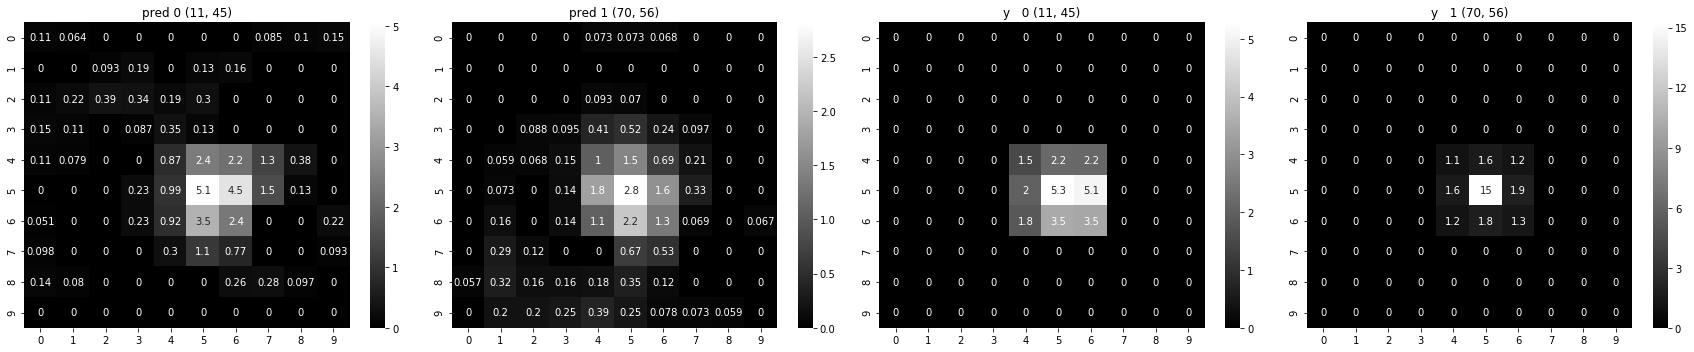

In [145]:
i = 2
myplot2(pred_matrix[i][0], y[i][0], y_f[i])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

/home/caitao/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


20 21 22 23 24 25 26 27 28 29 30 31 

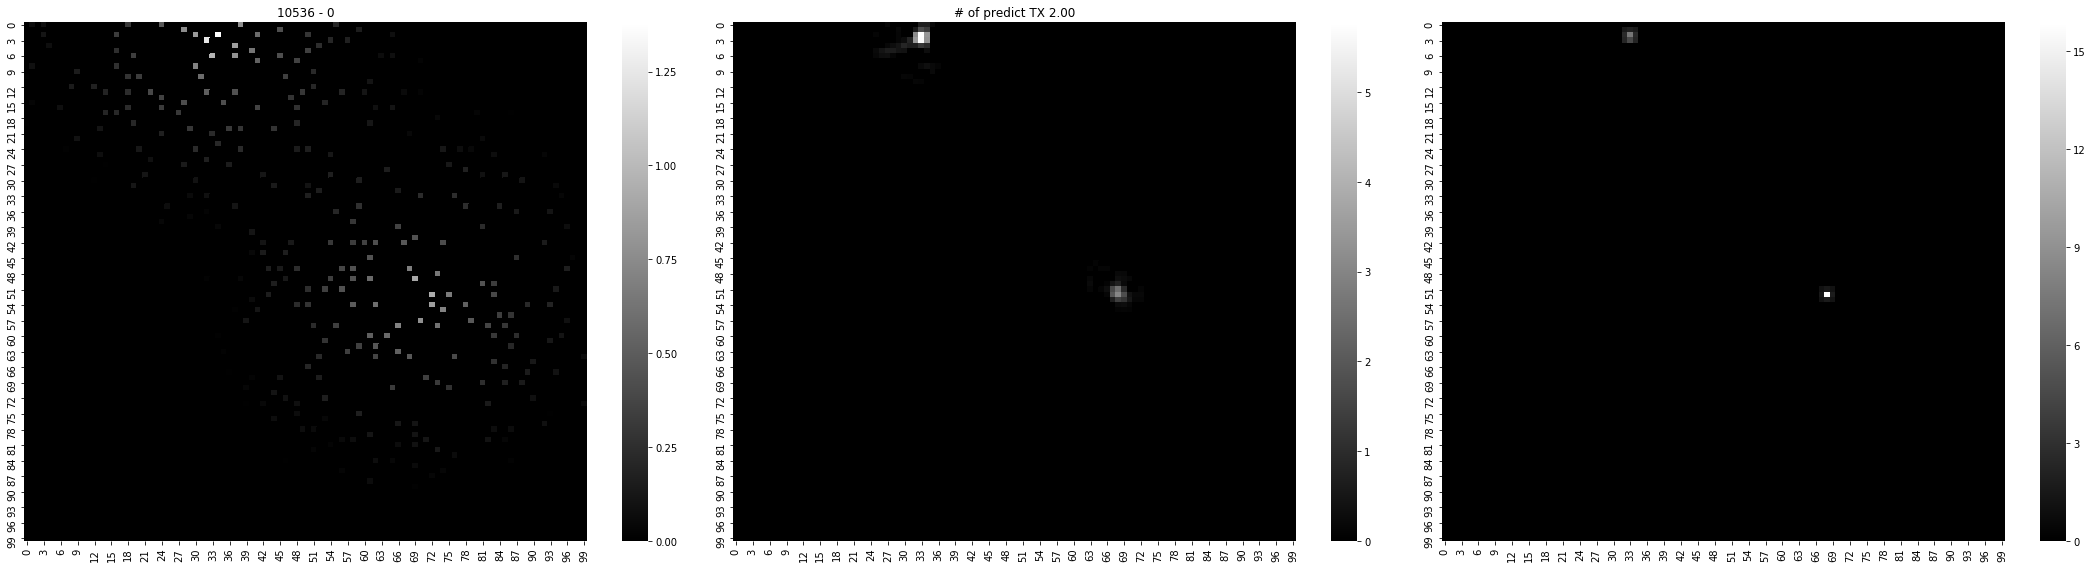

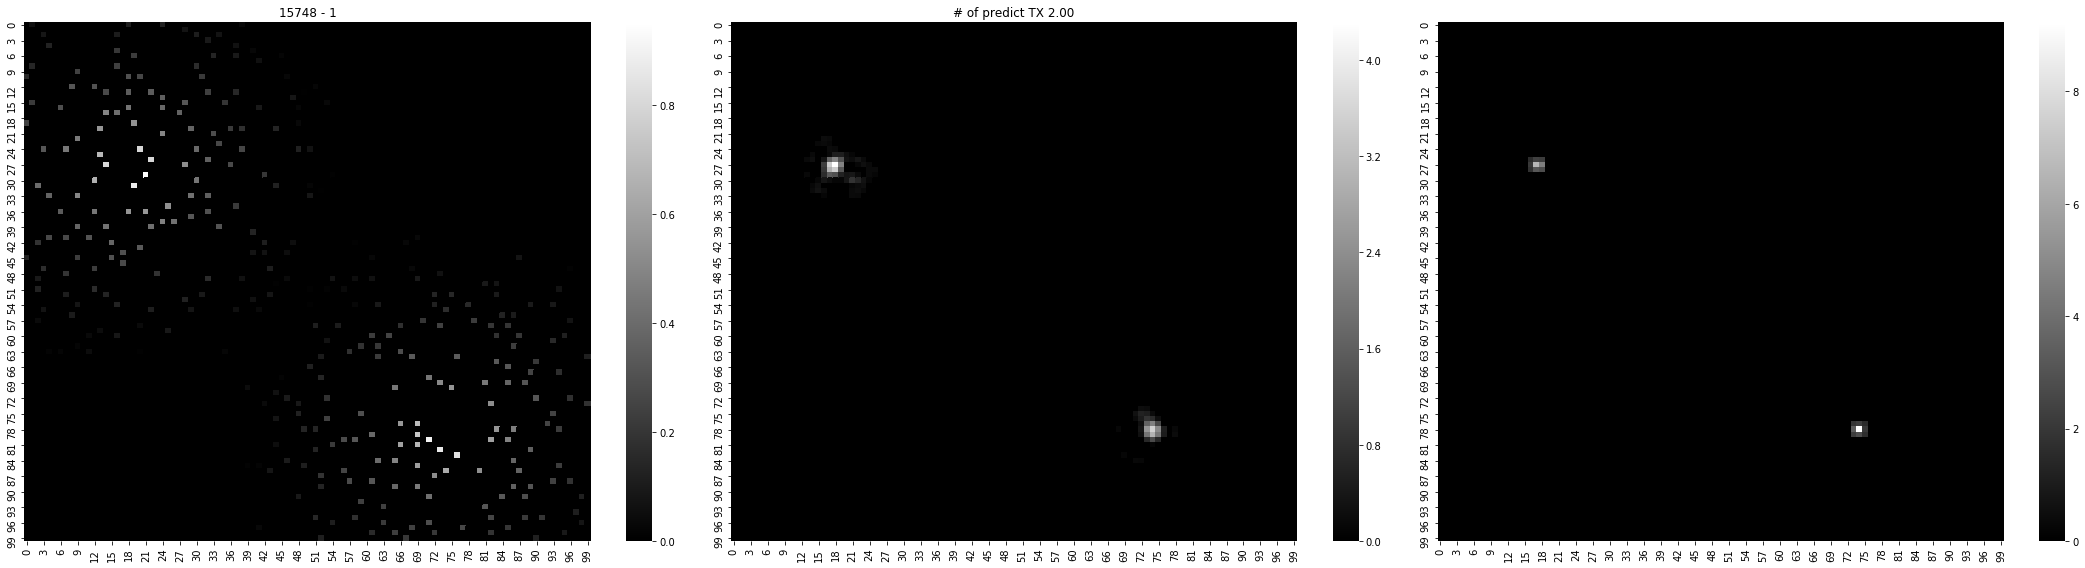

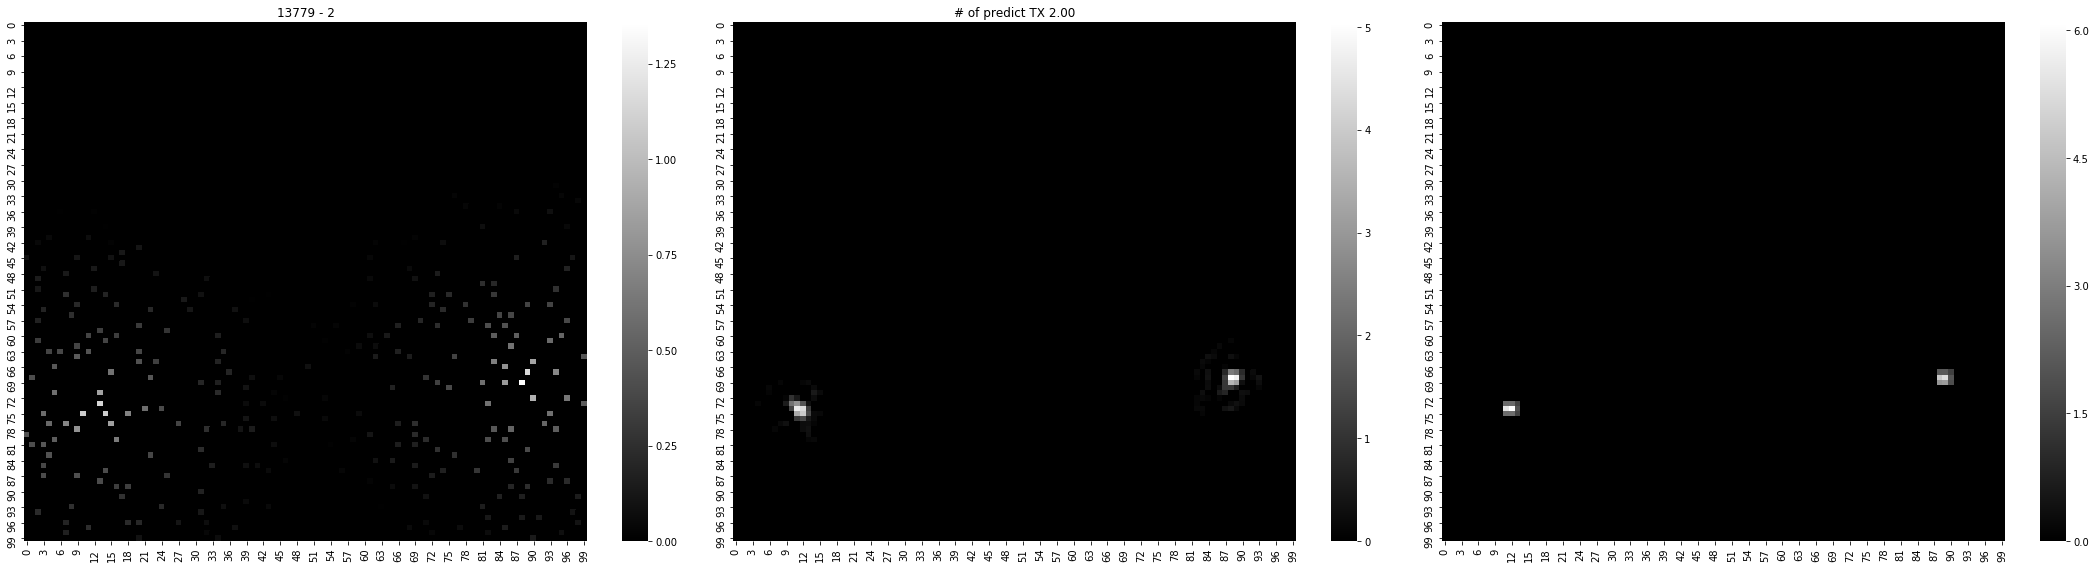

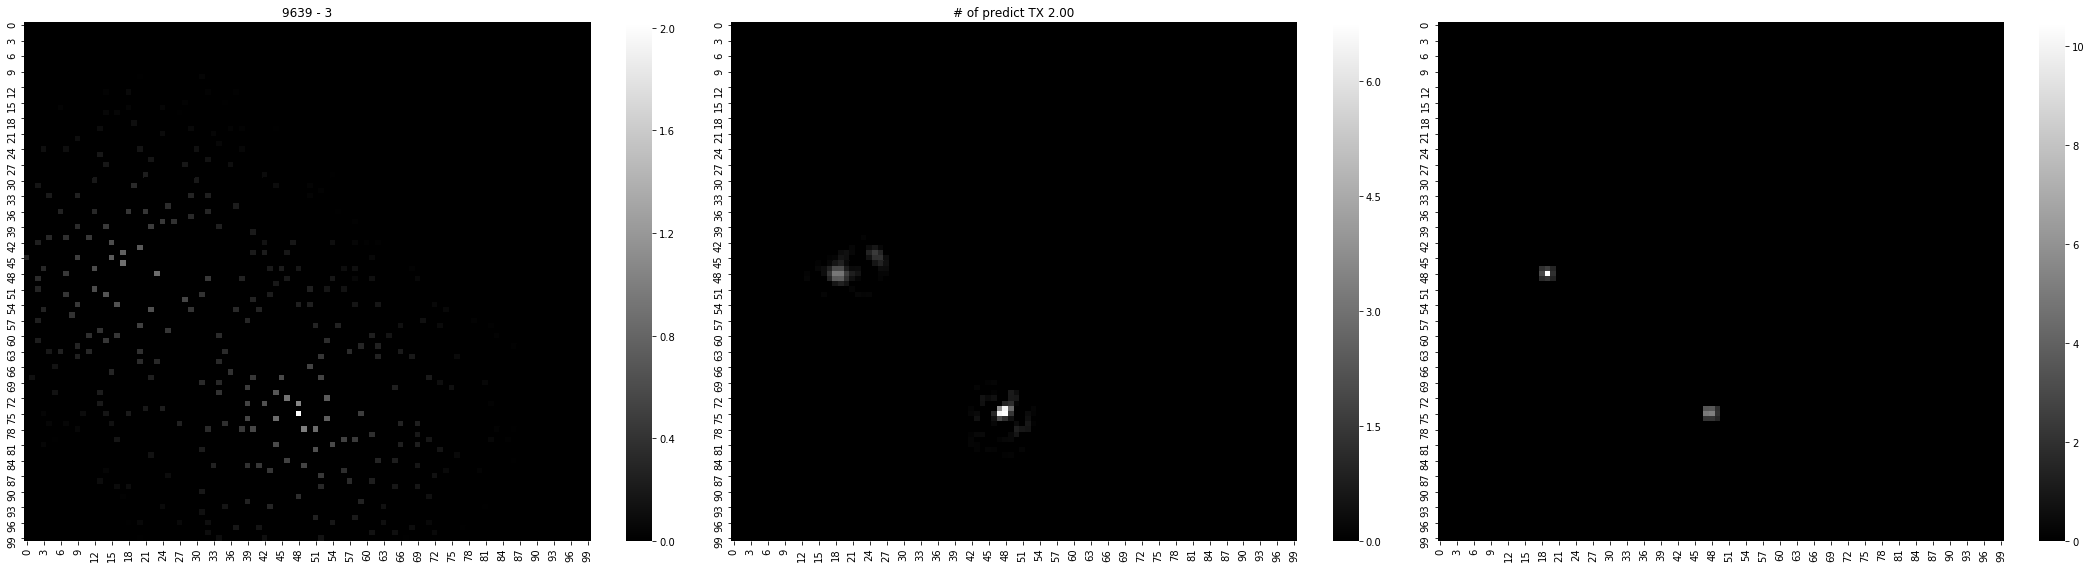

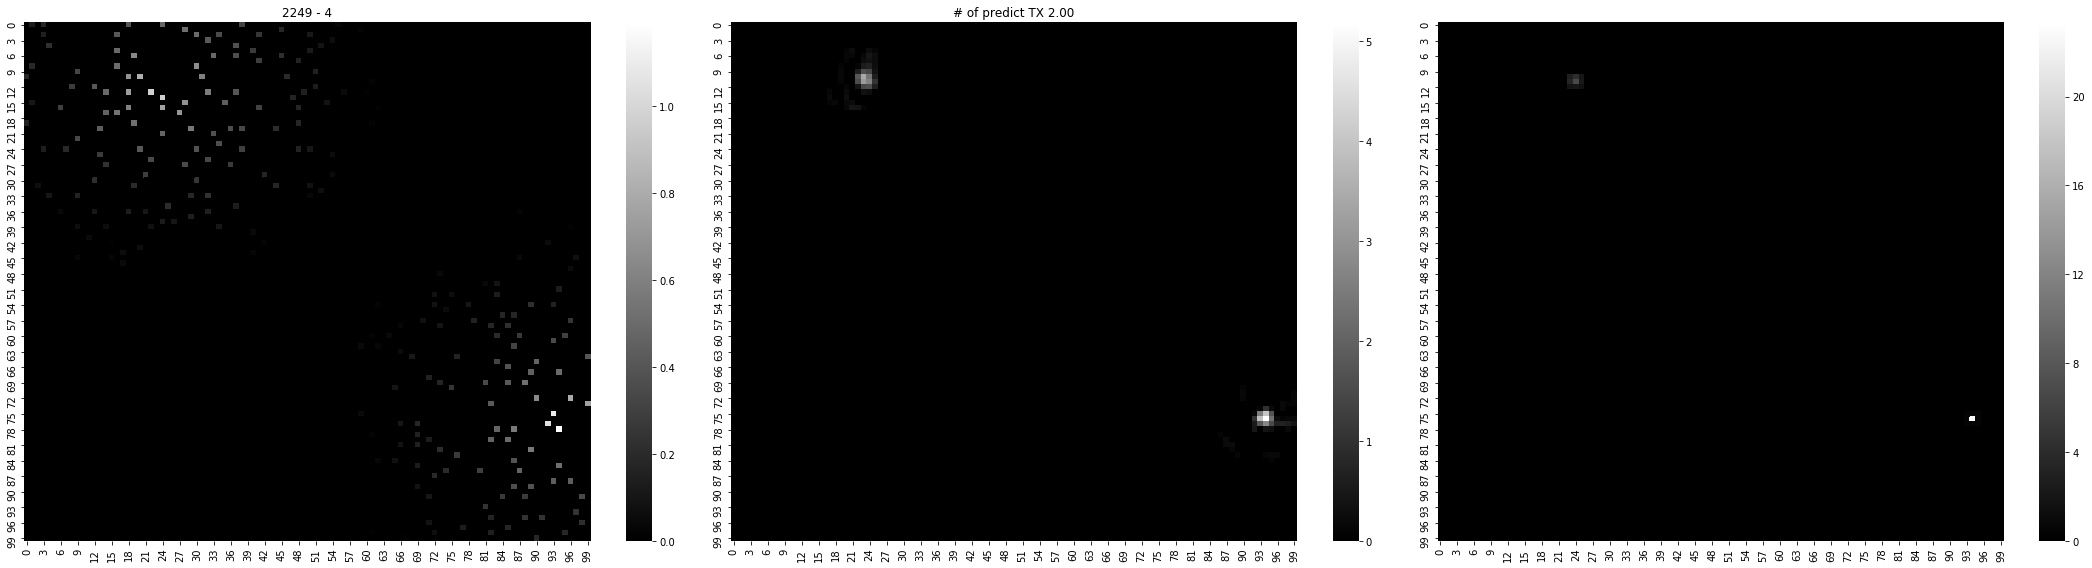

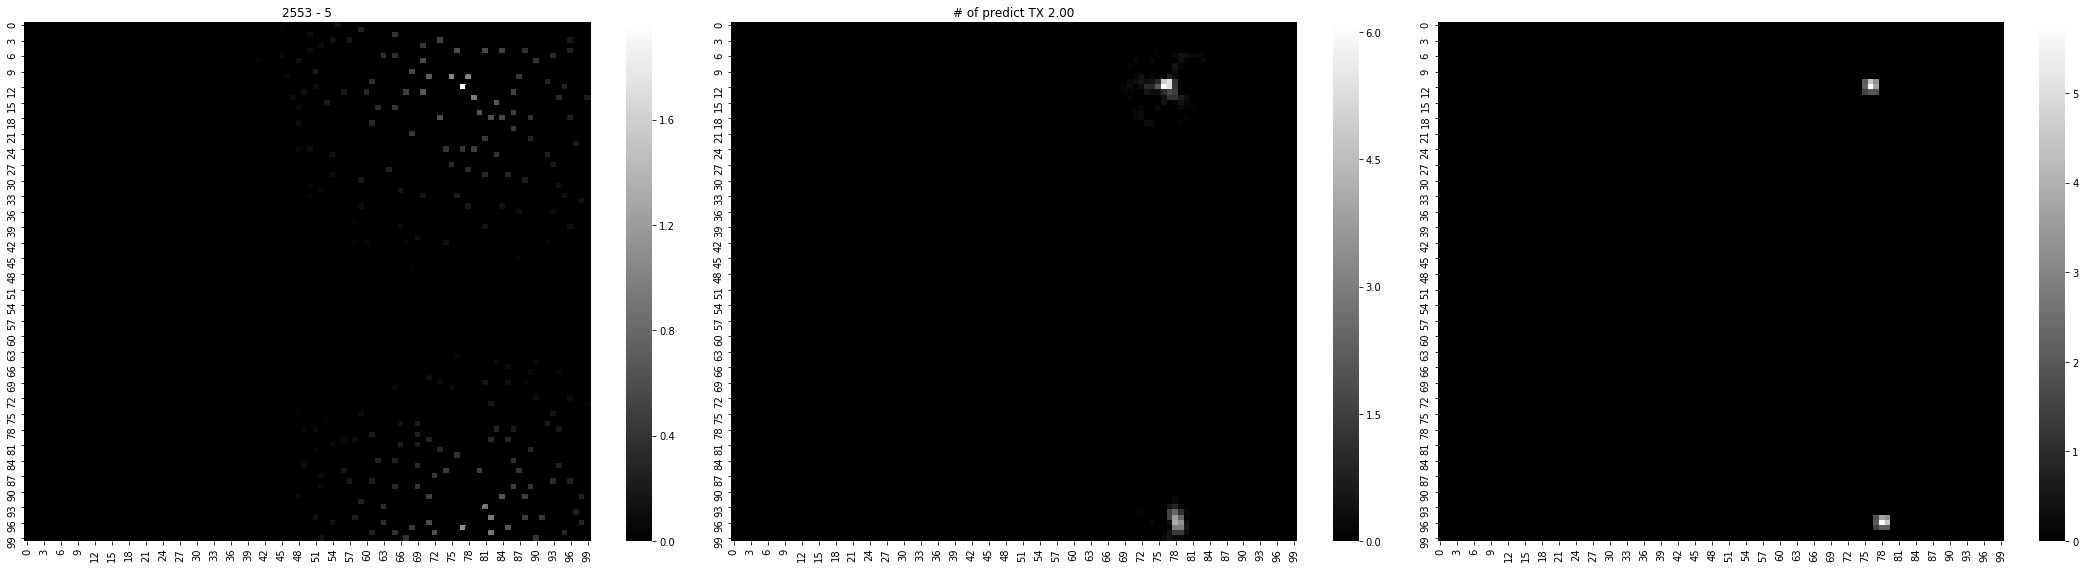

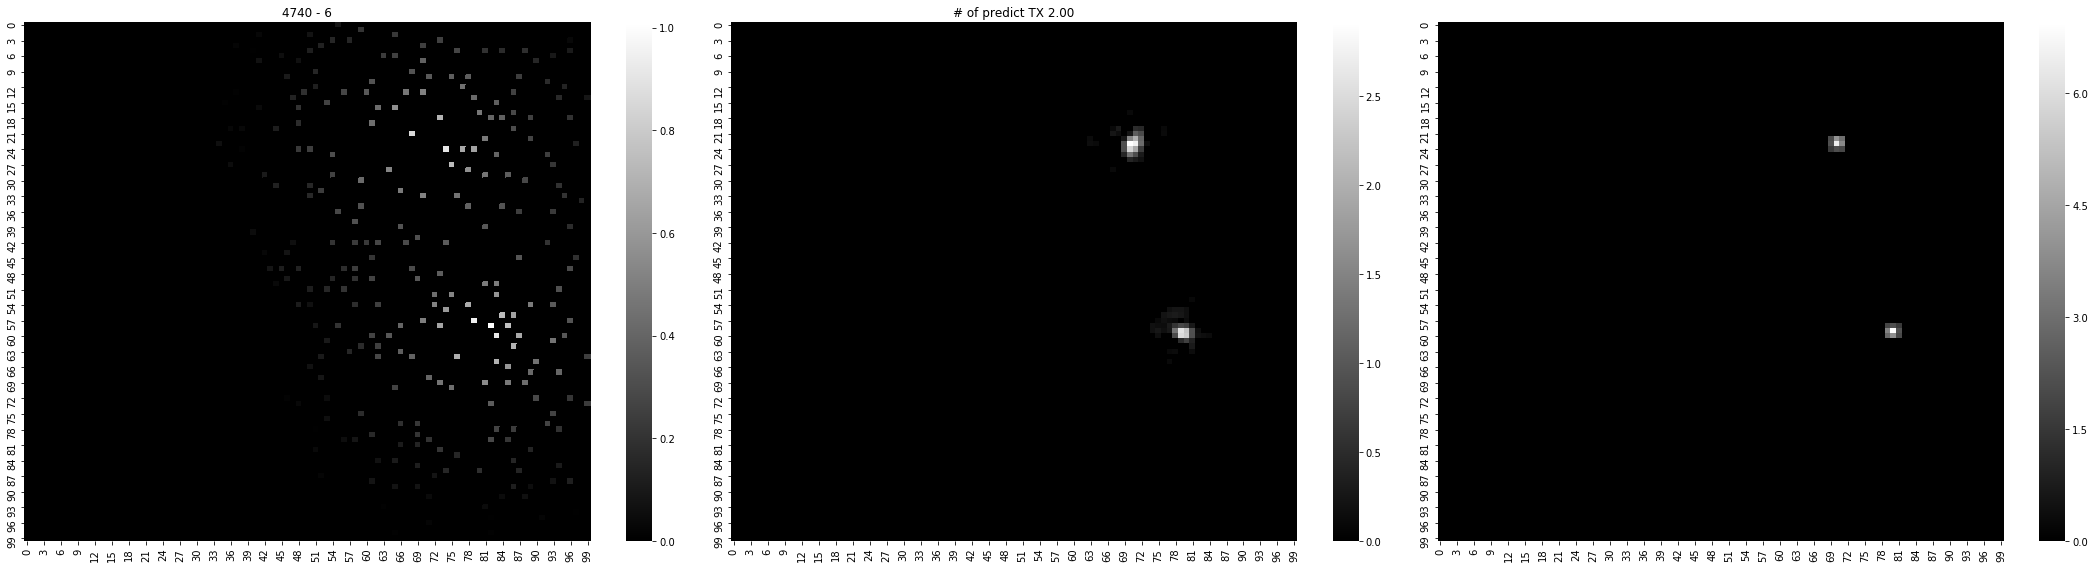

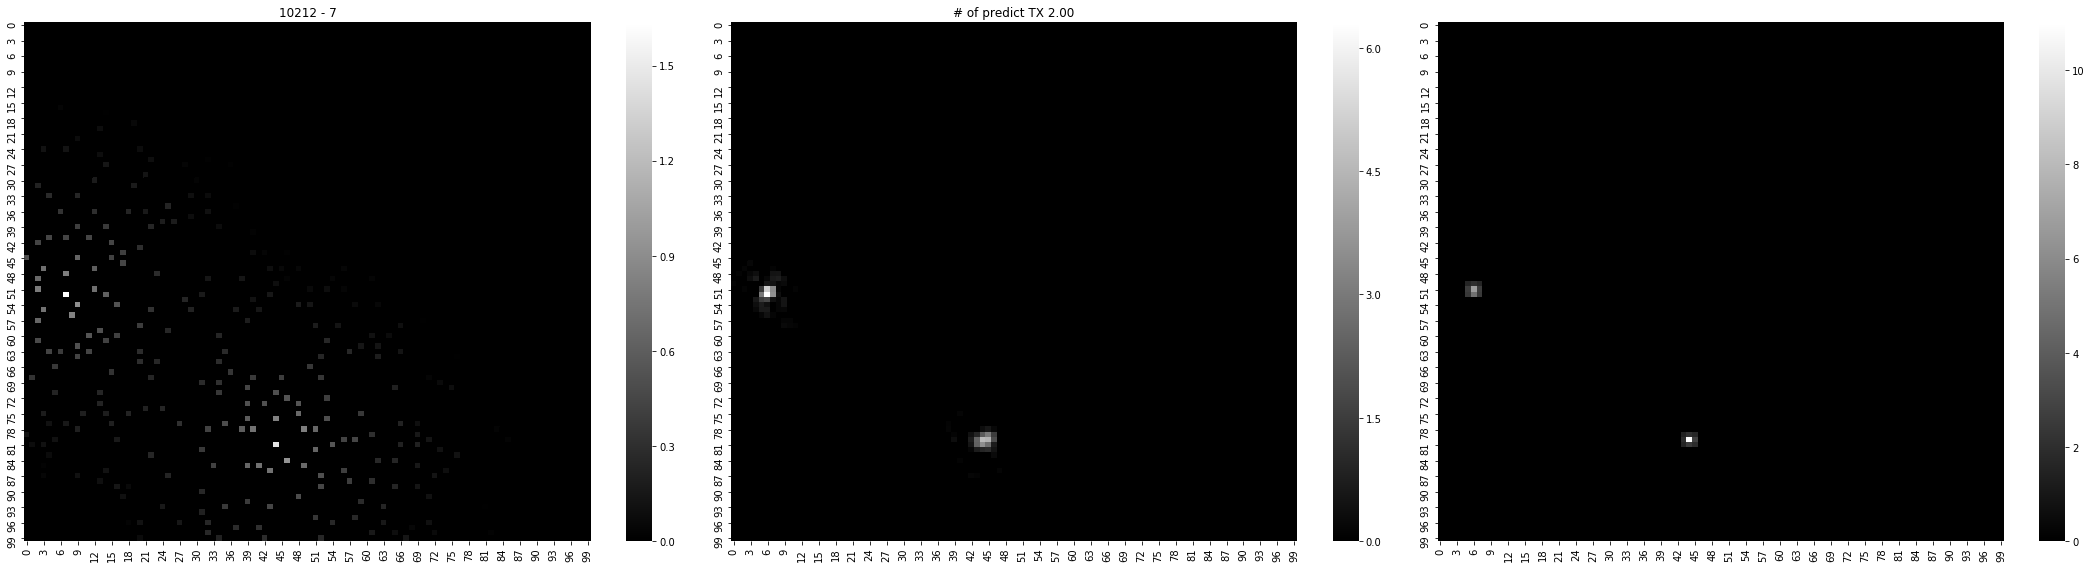

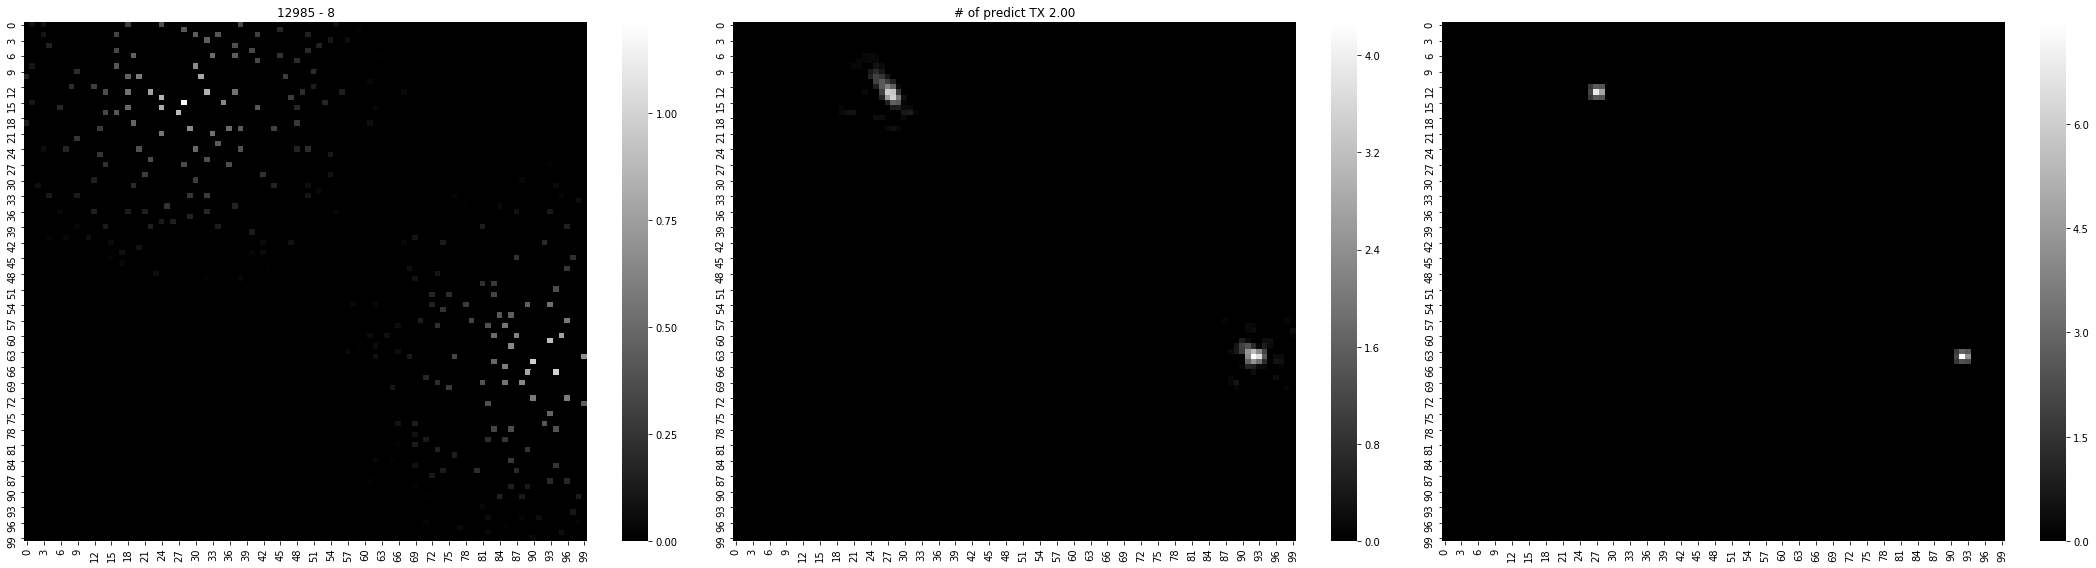

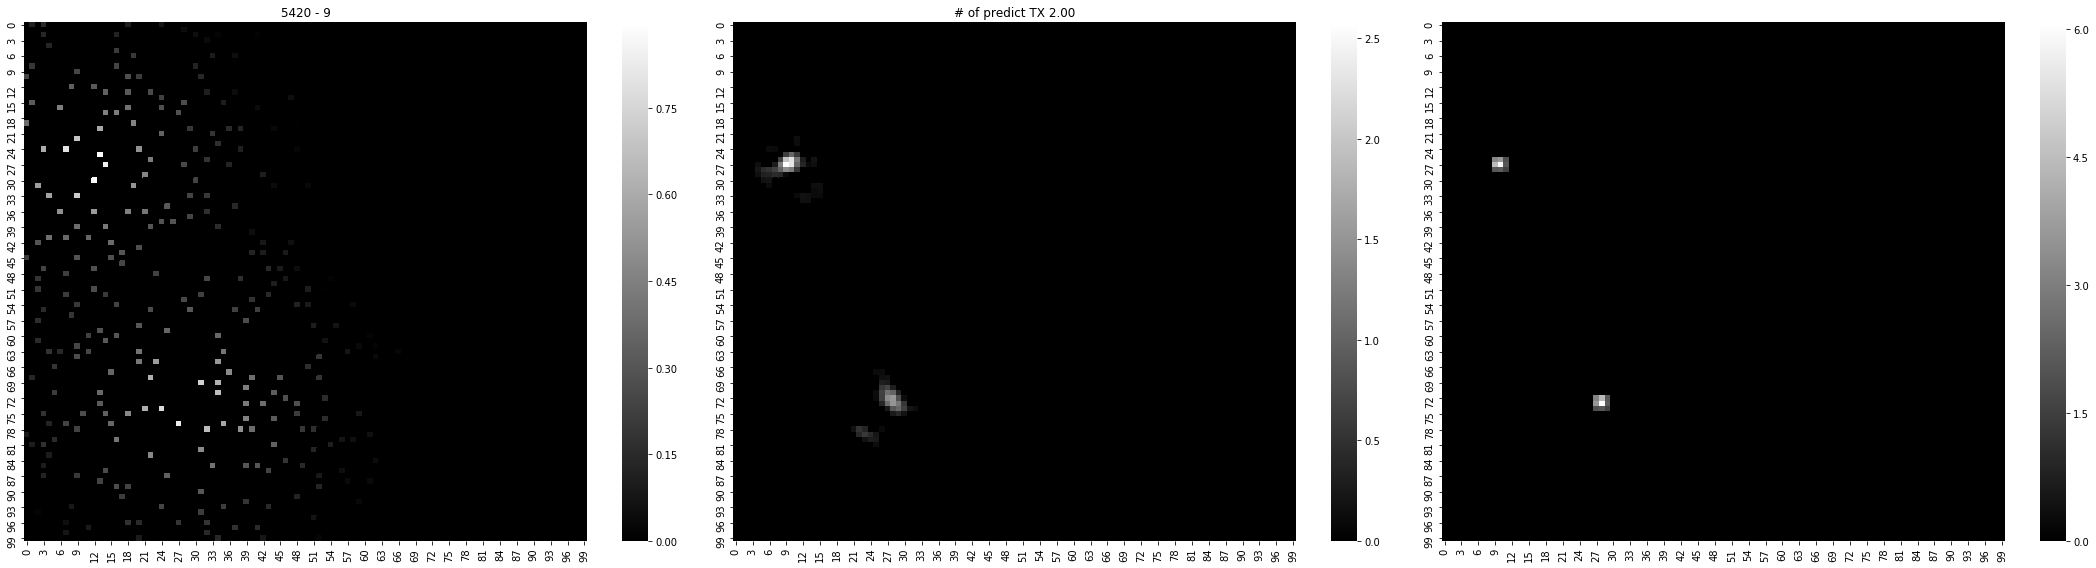

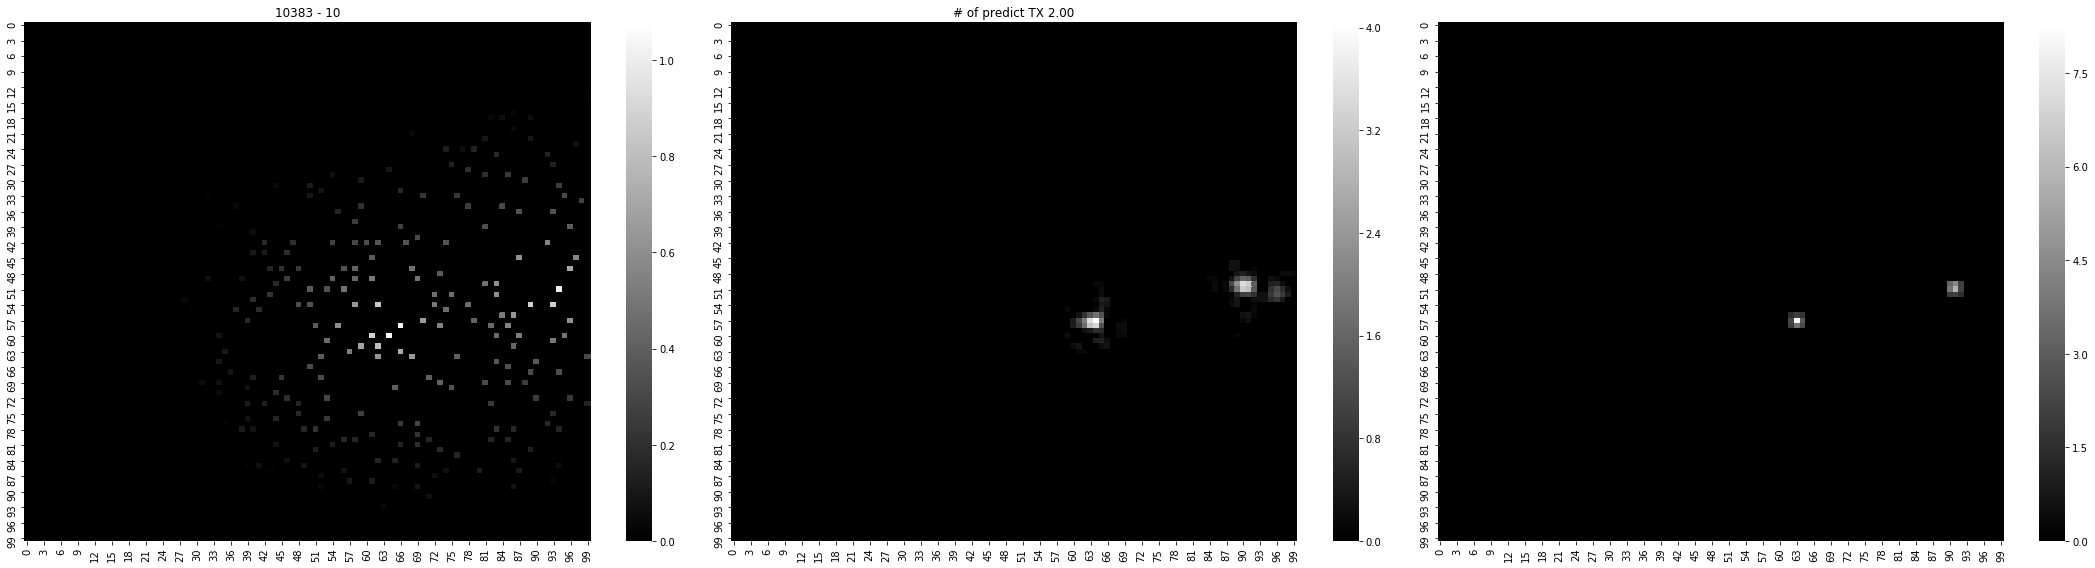

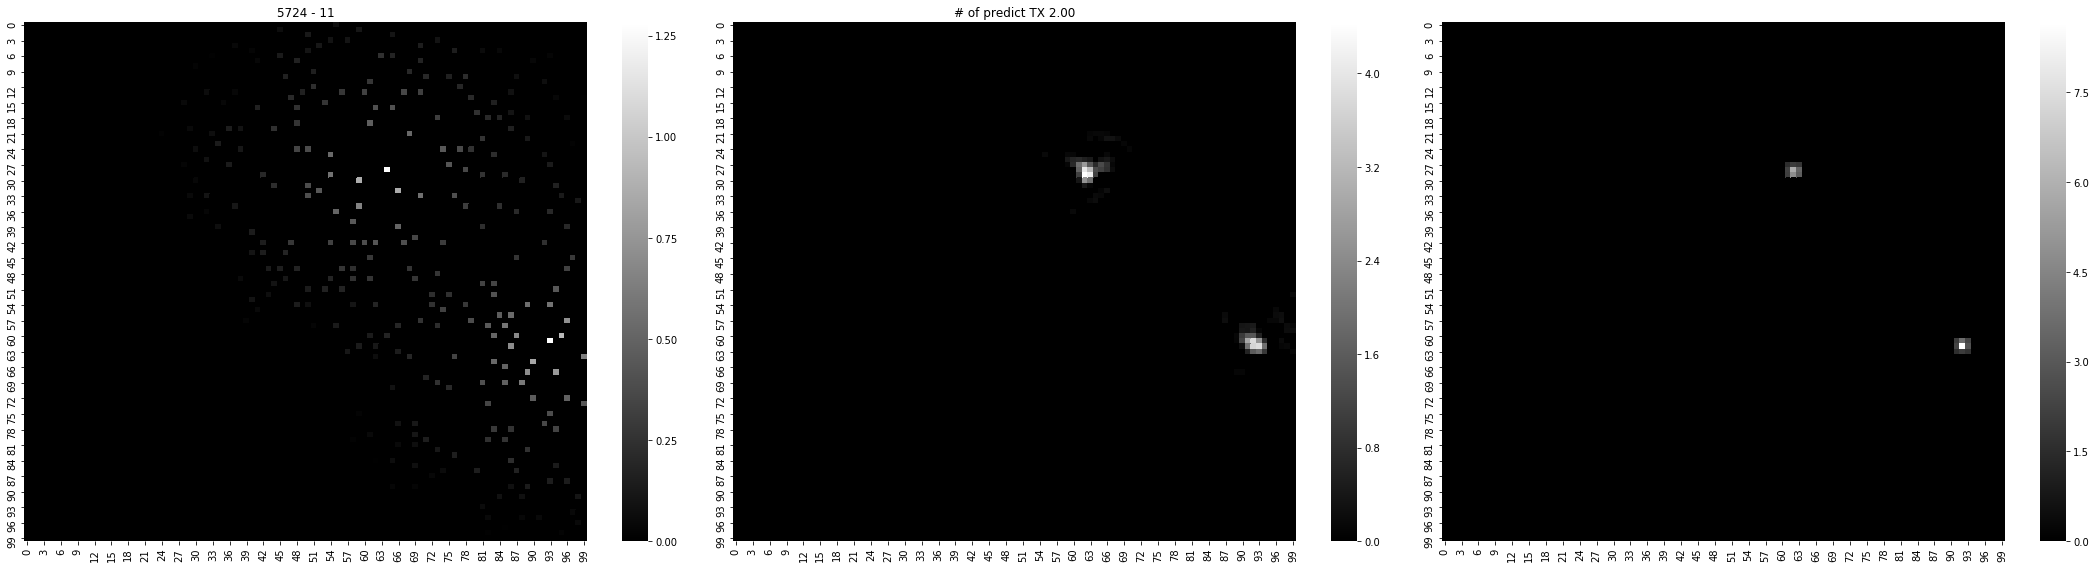

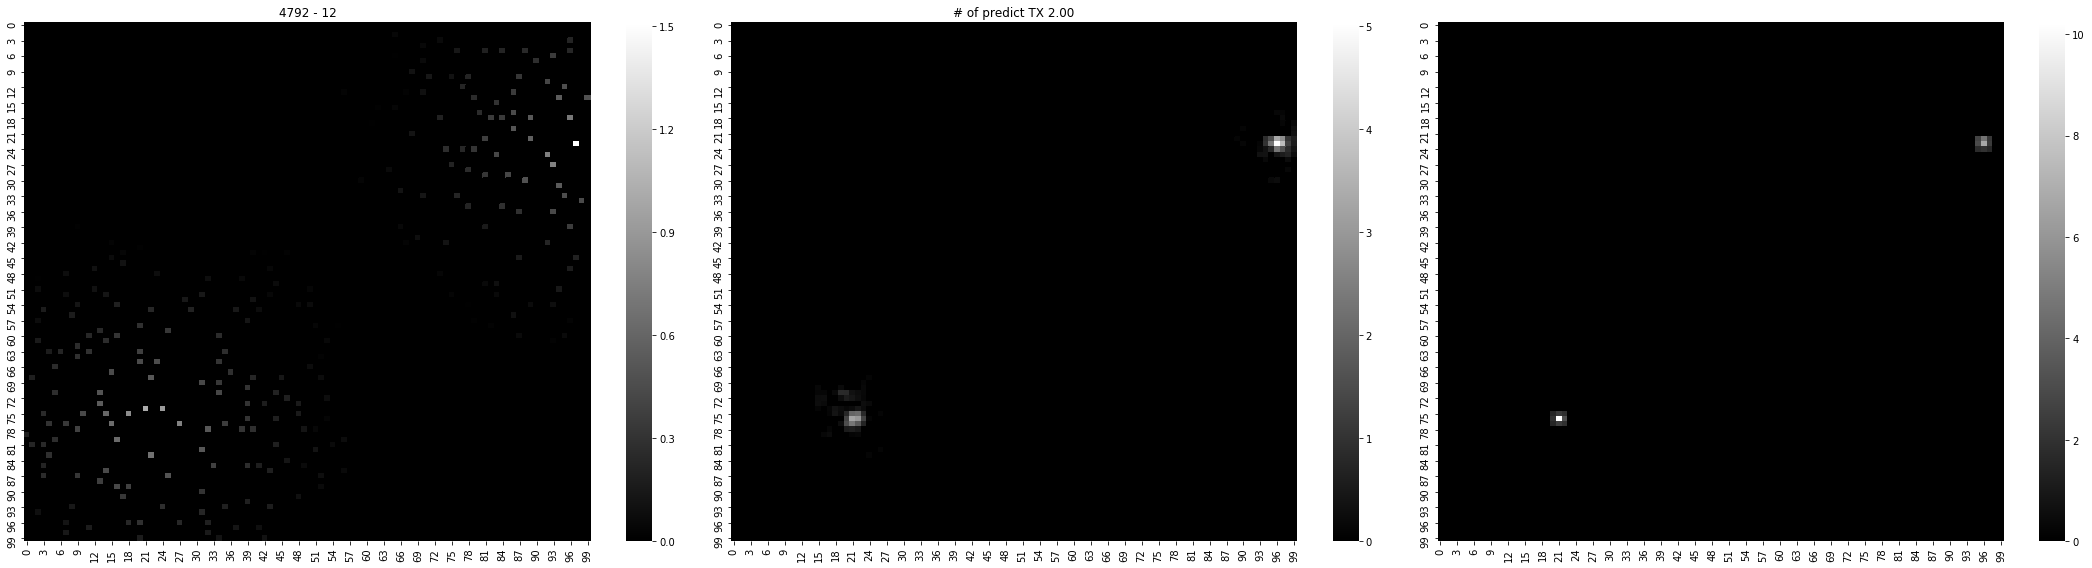

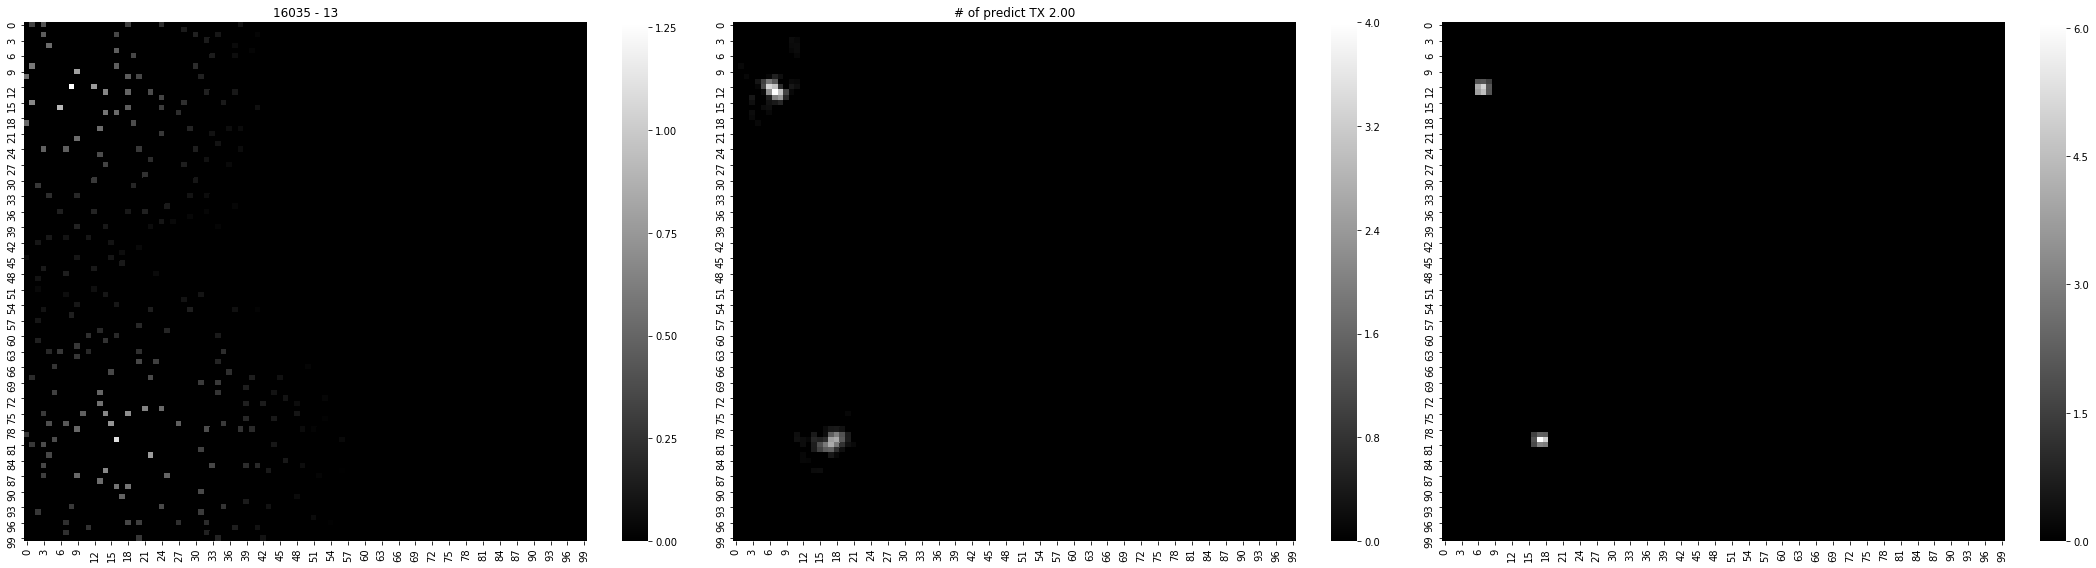

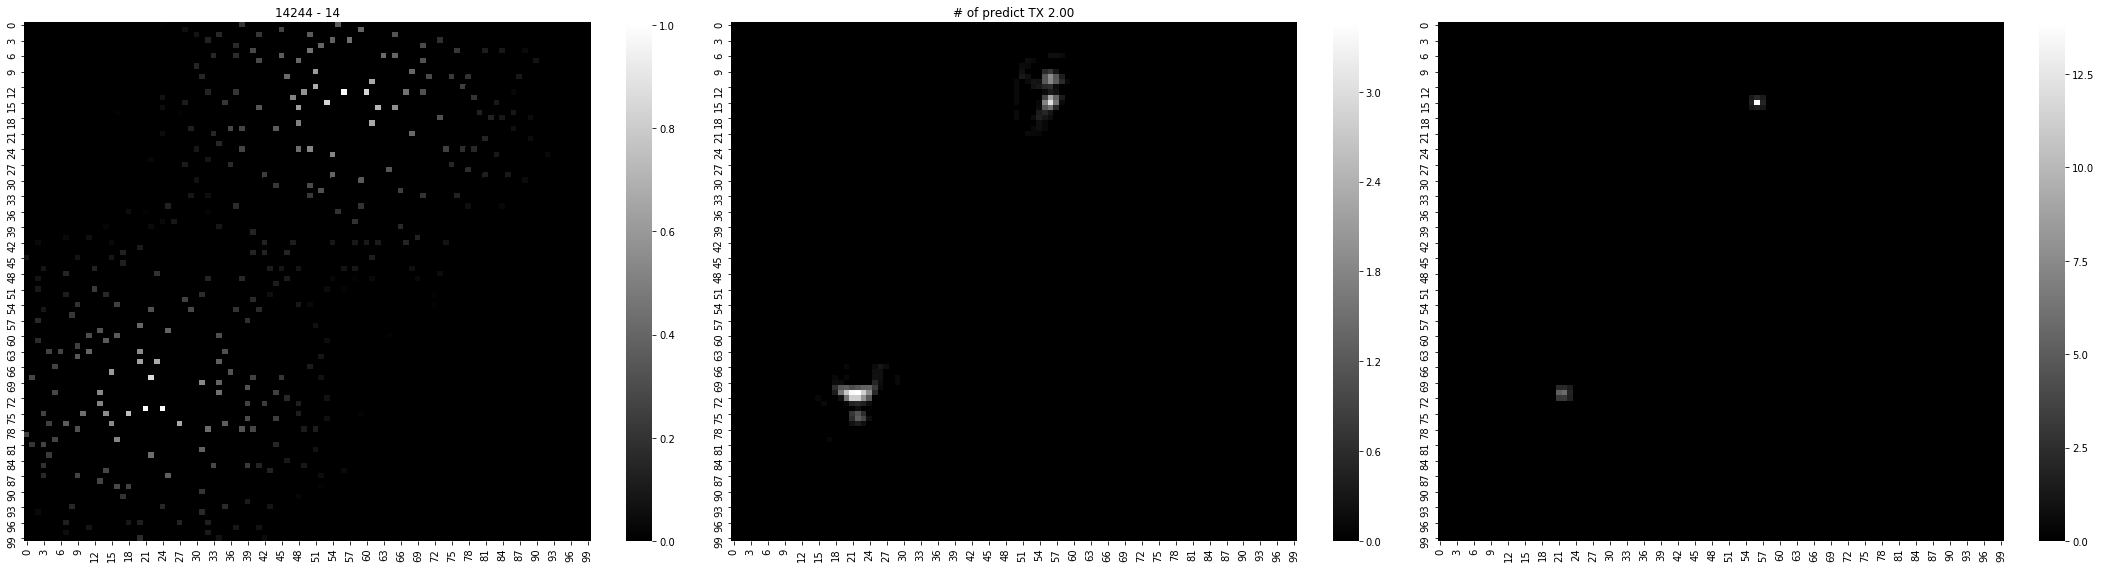

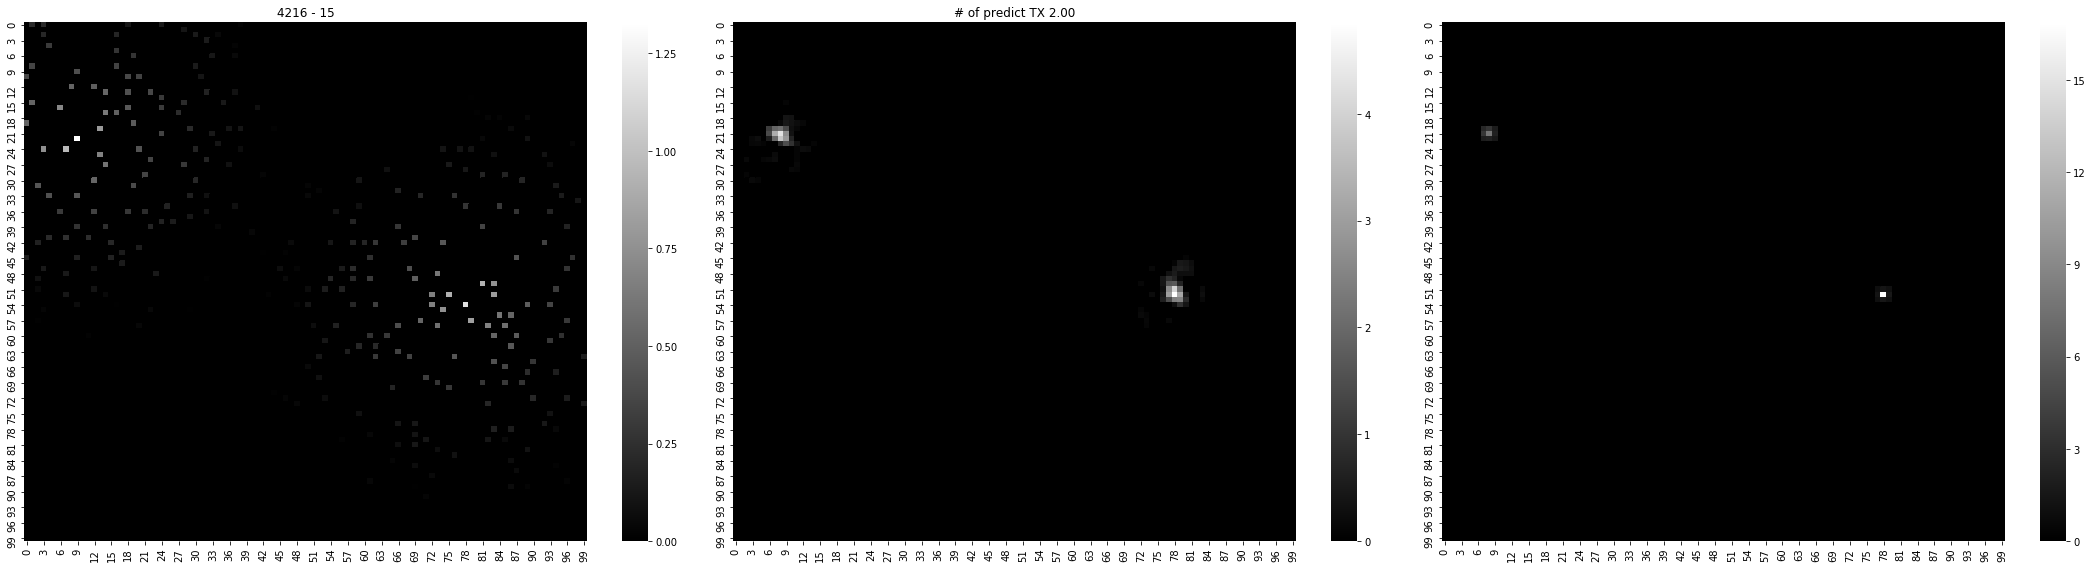

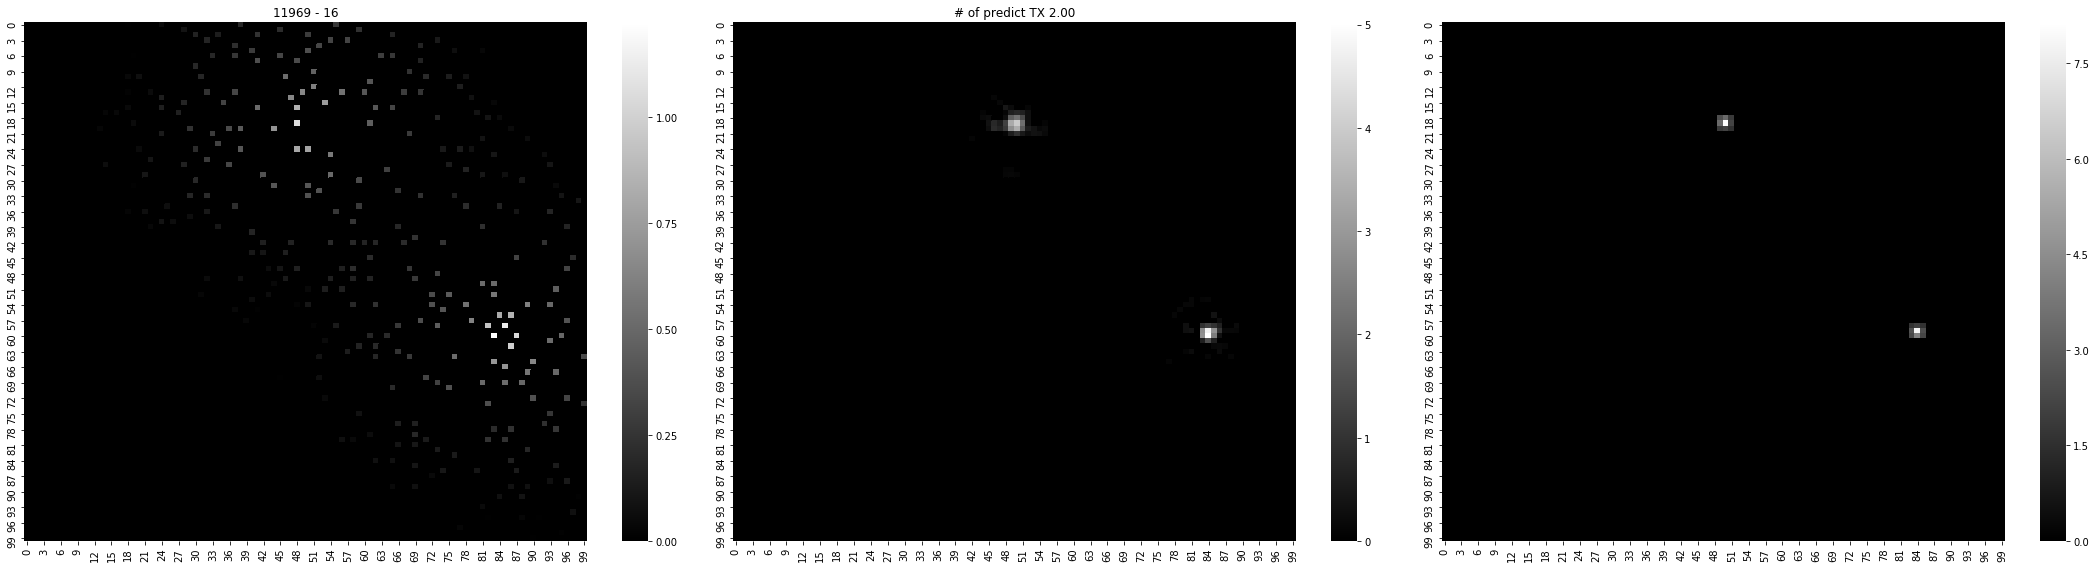

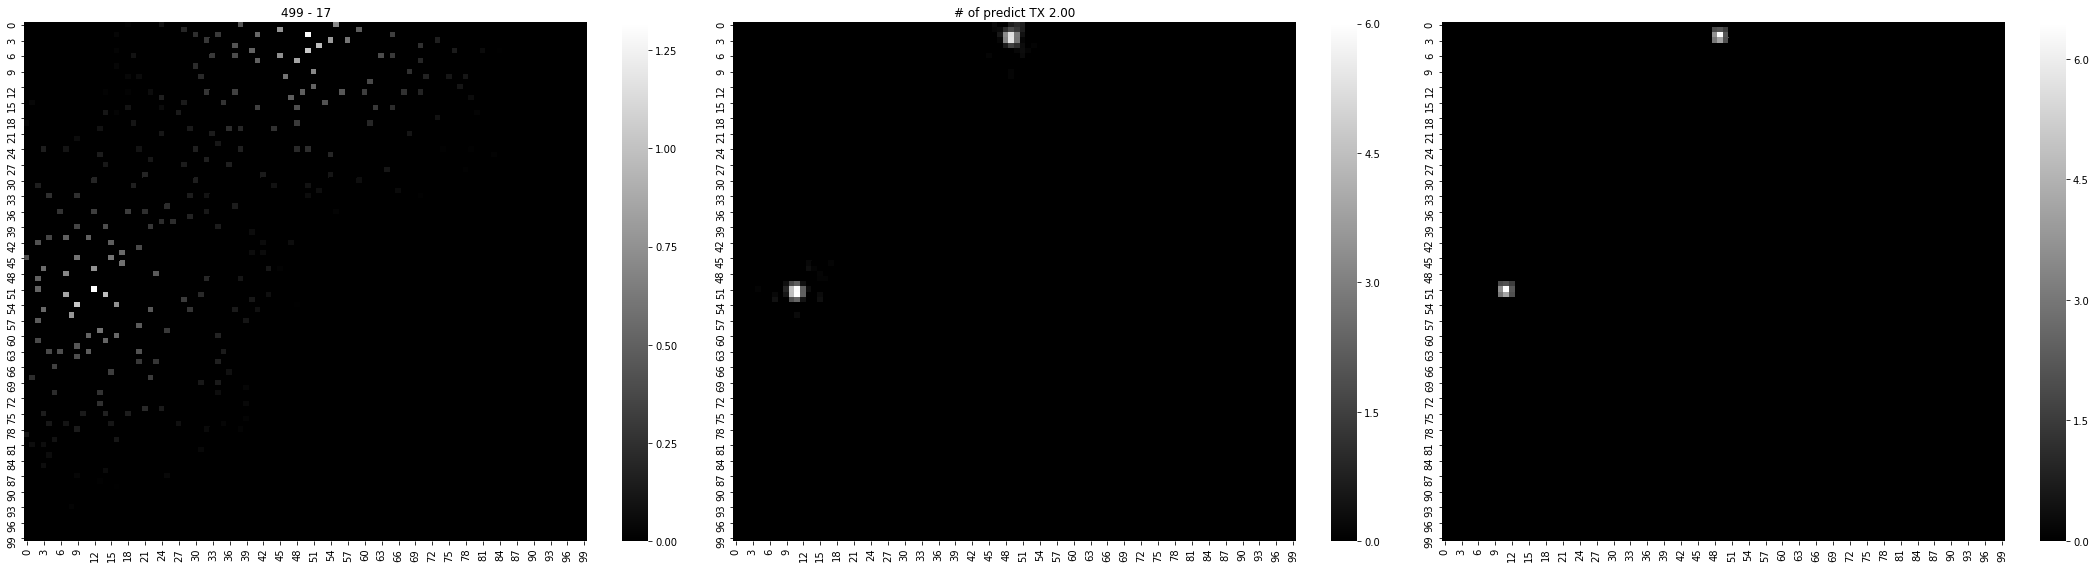

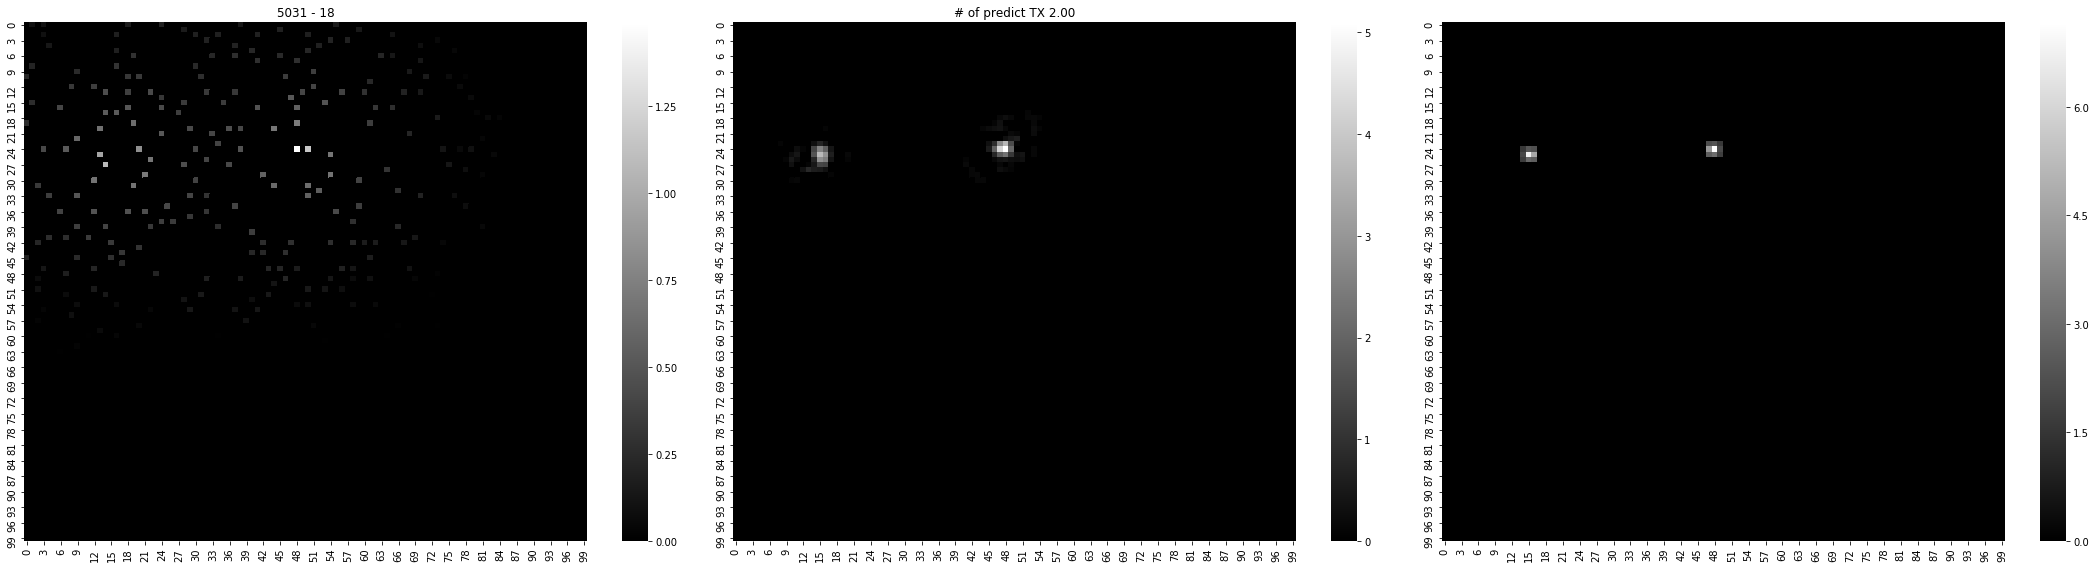

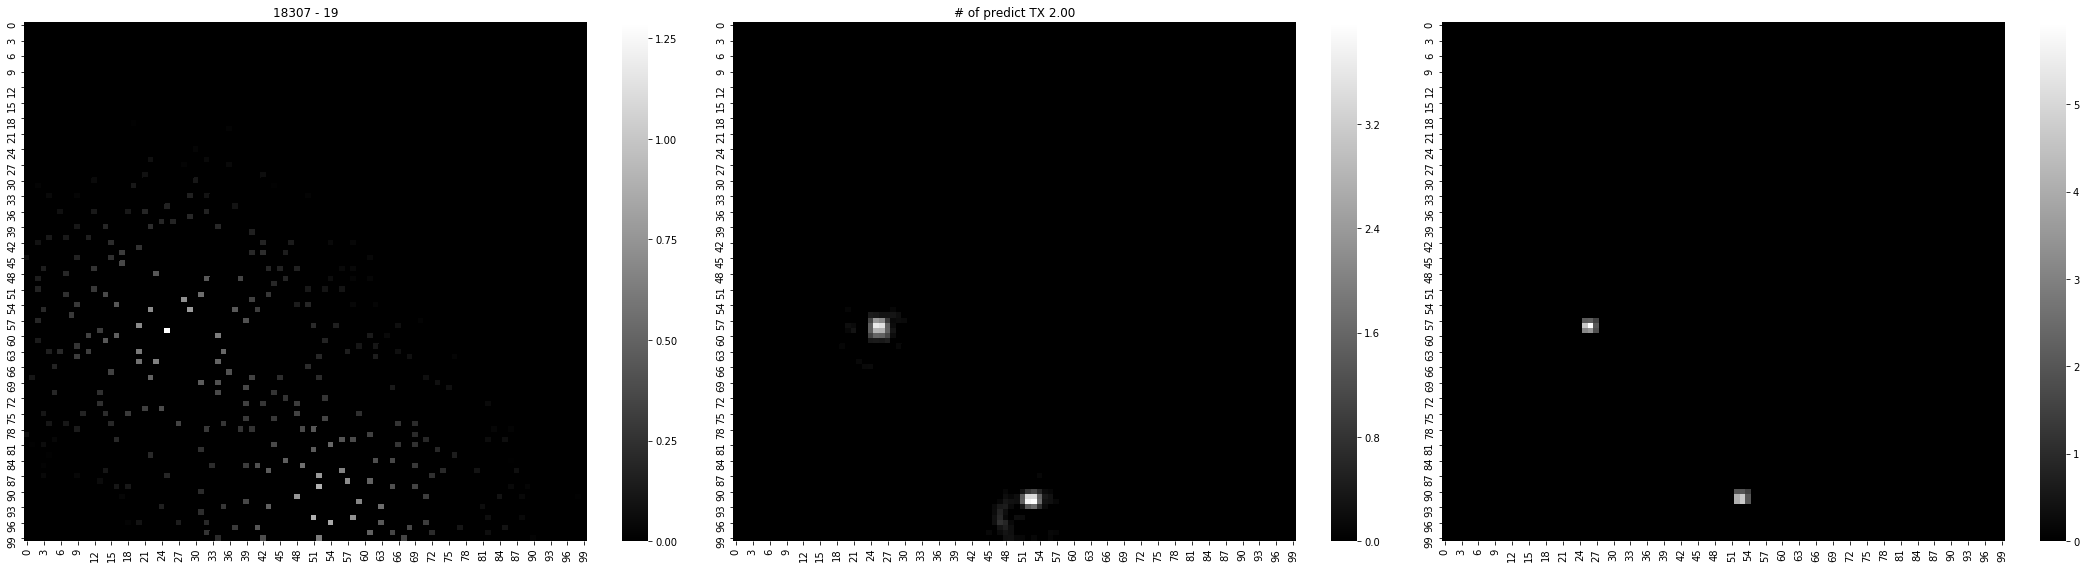

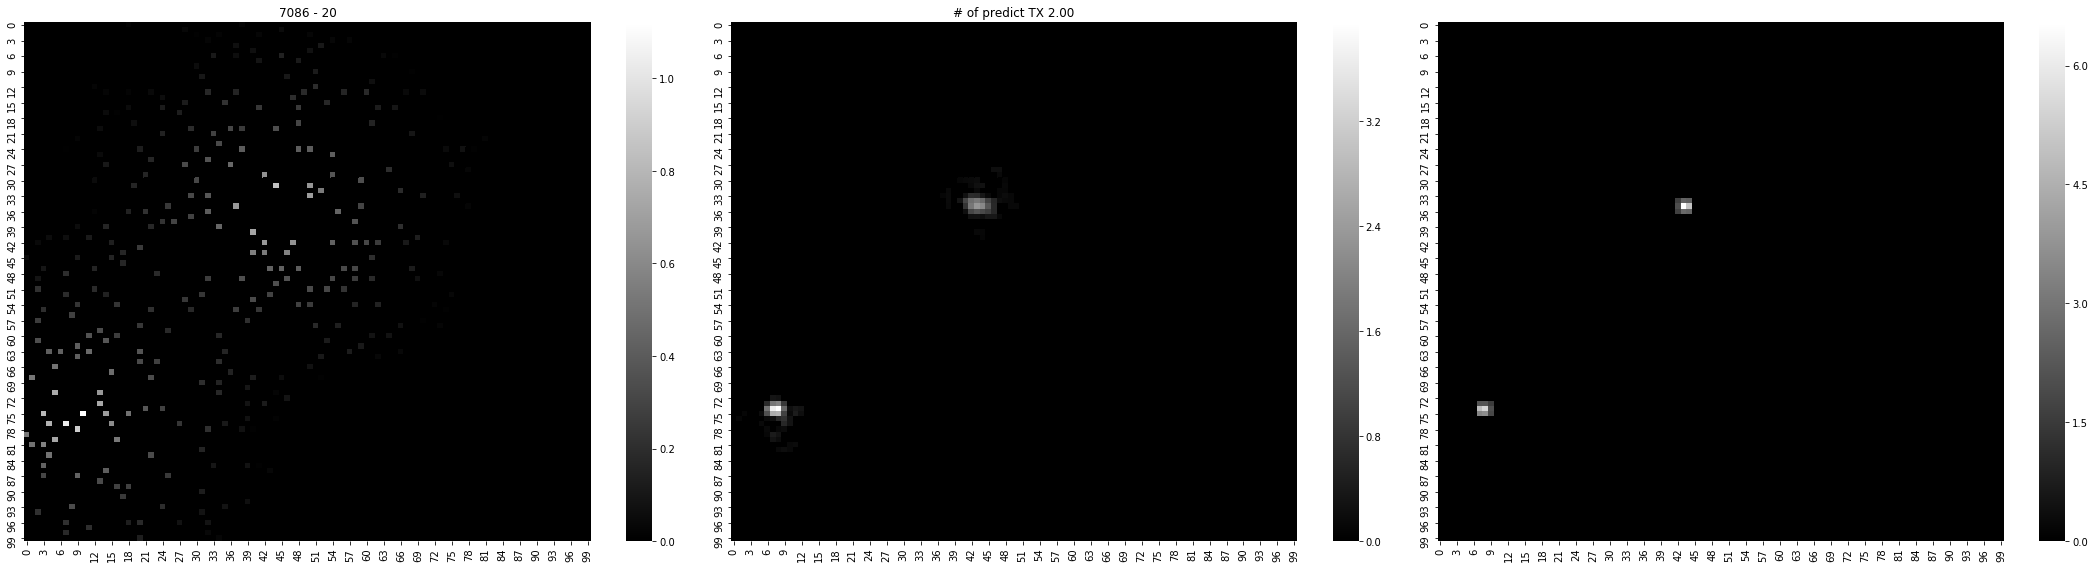

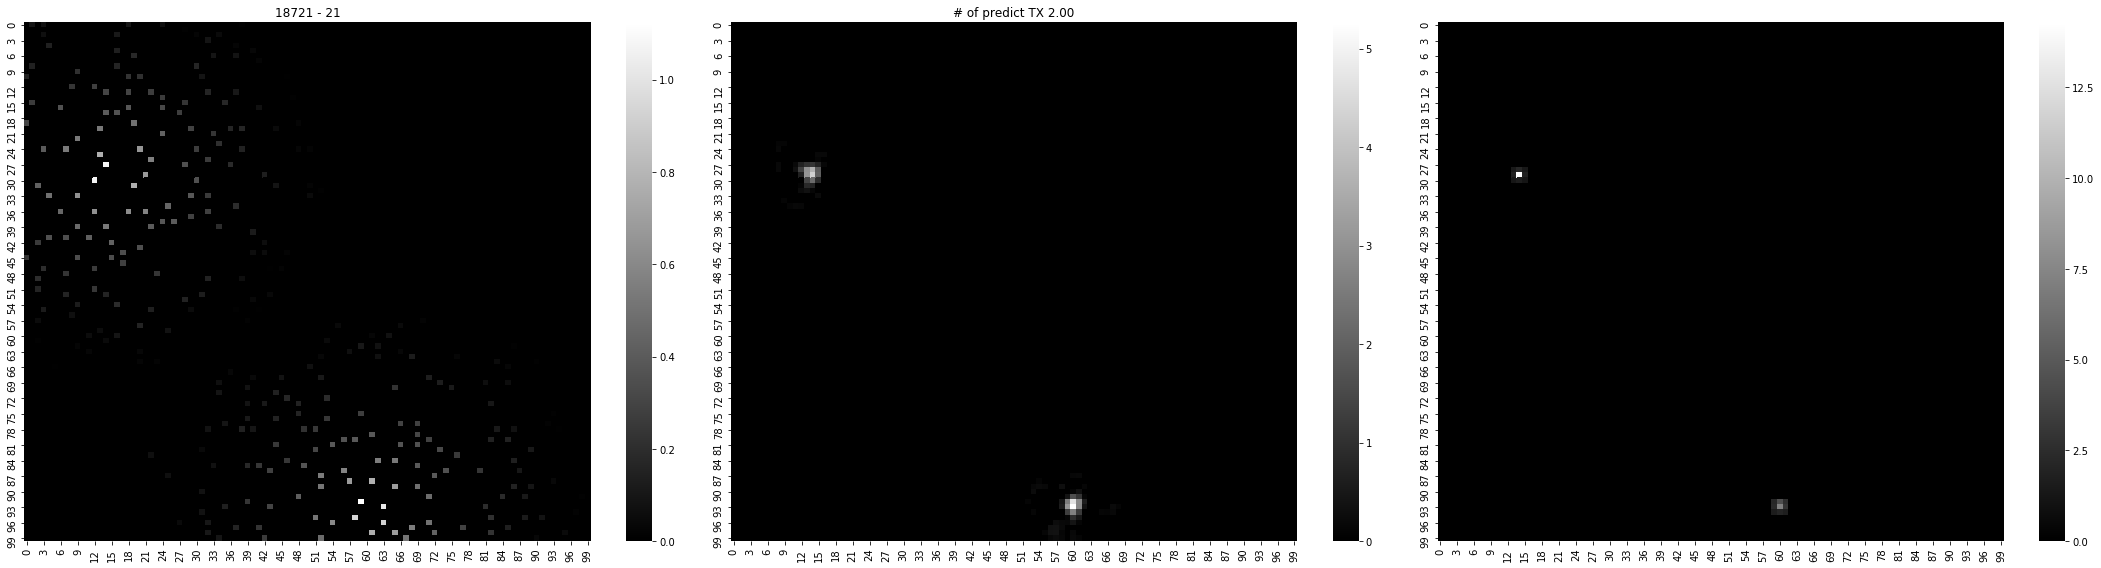

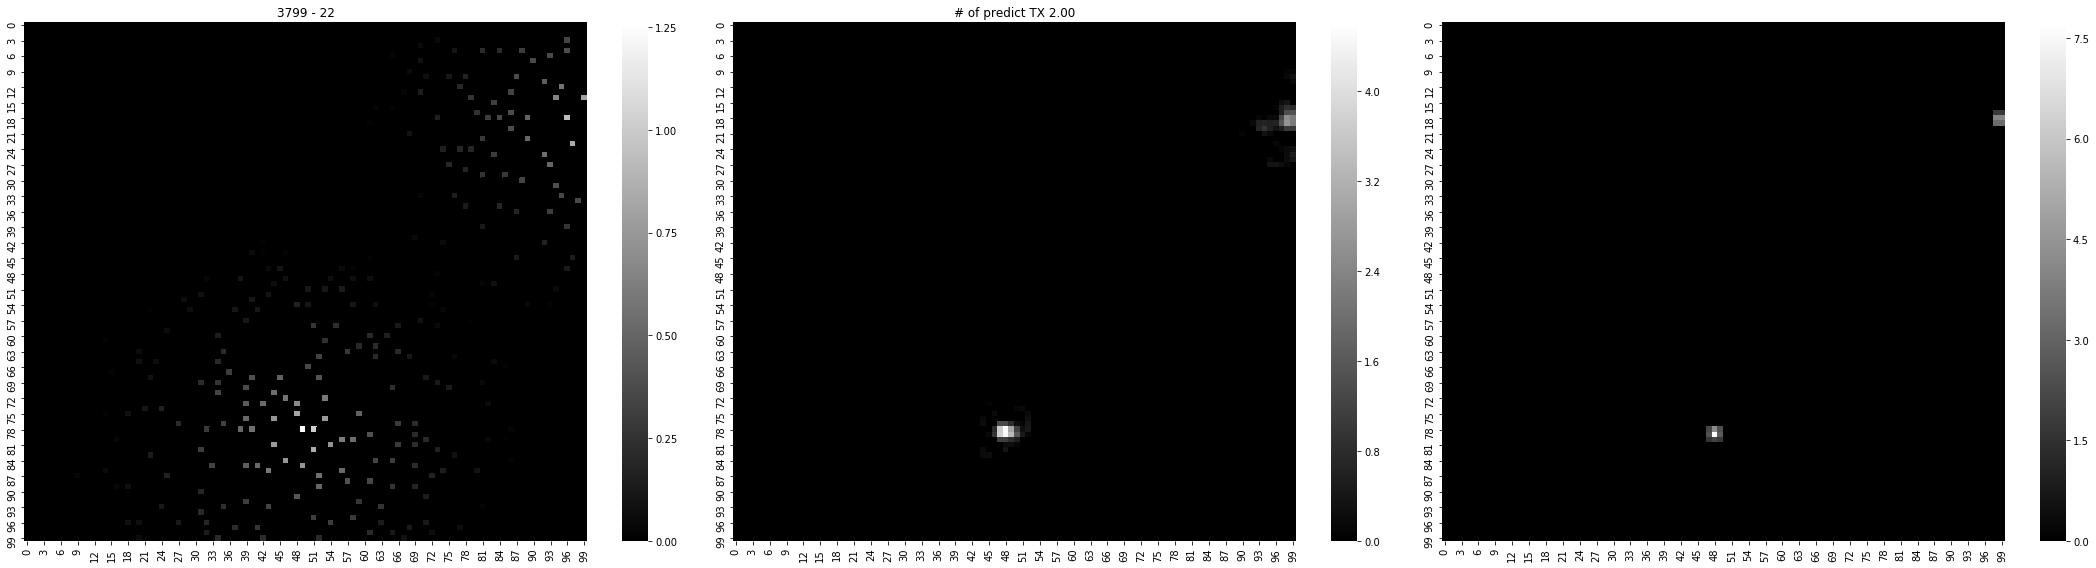

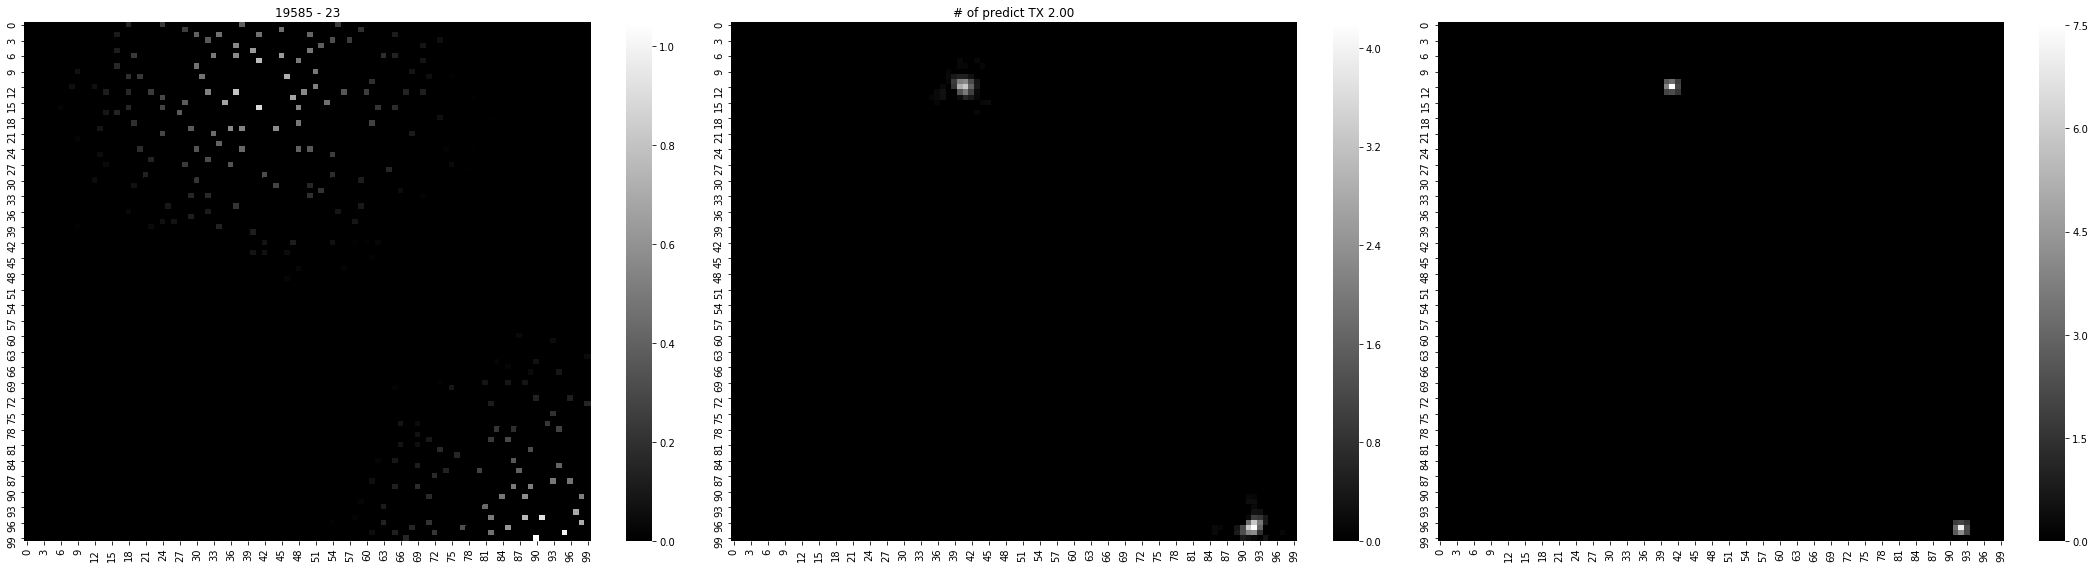

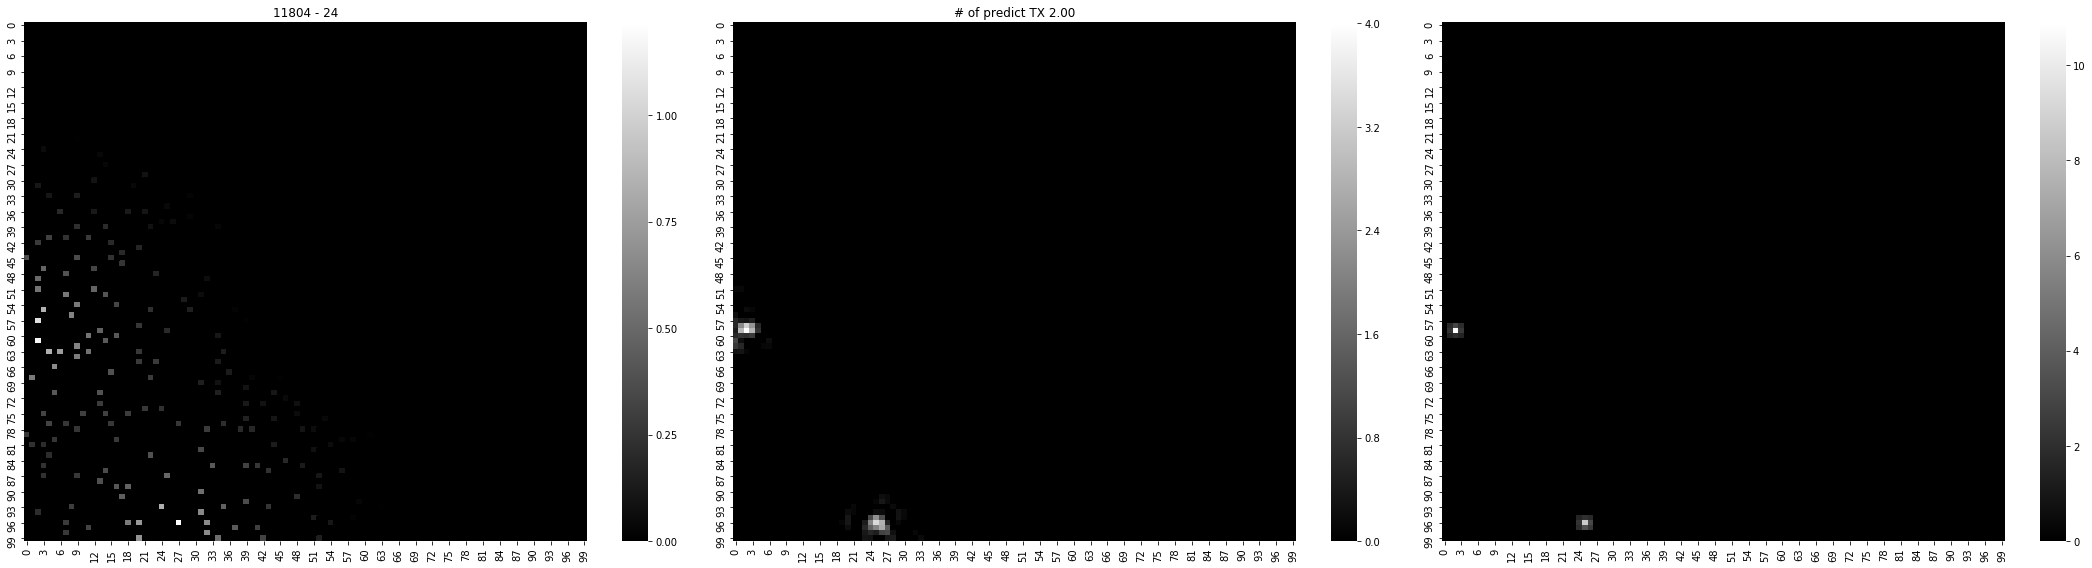

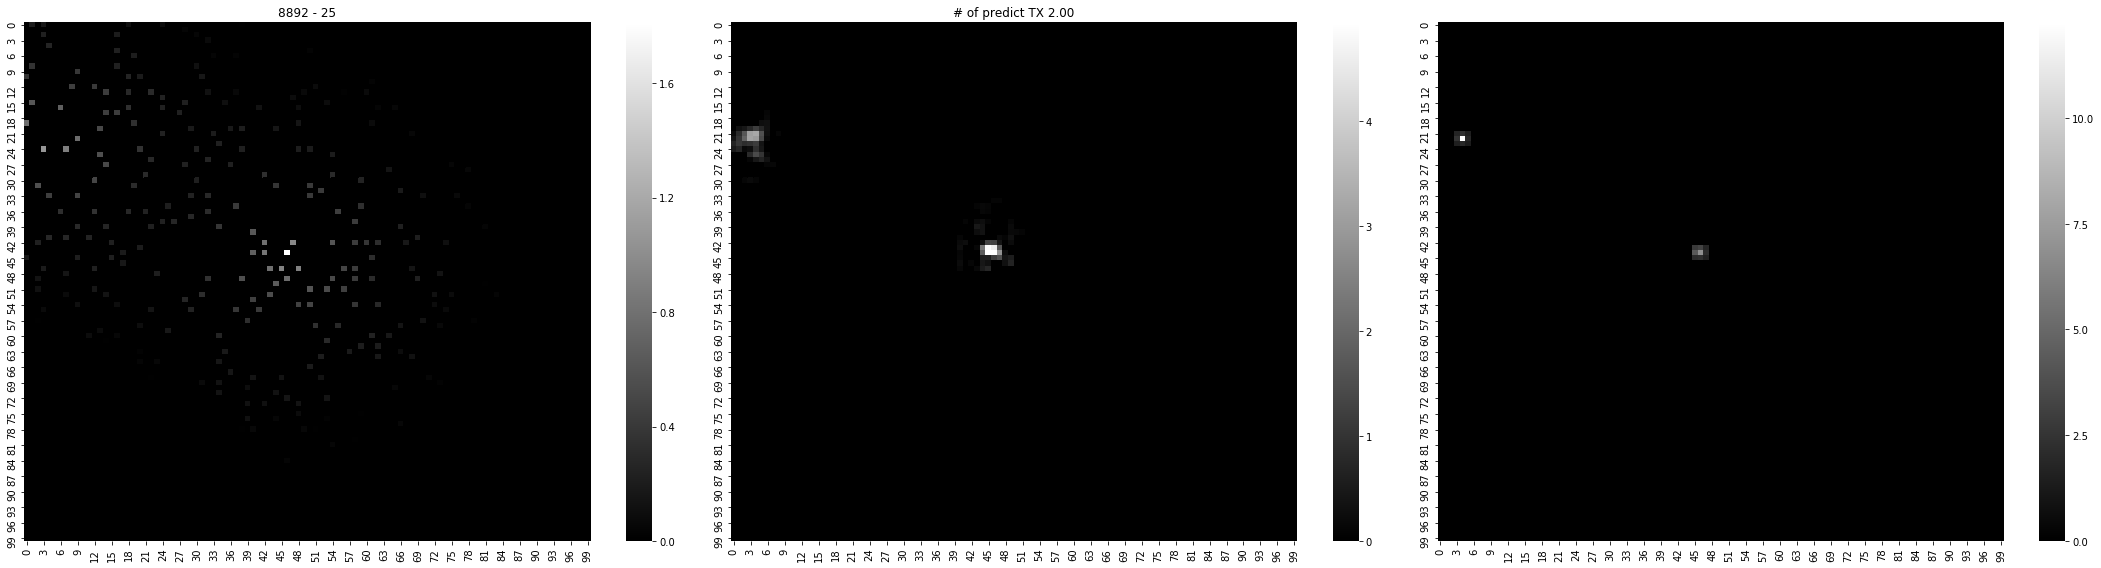

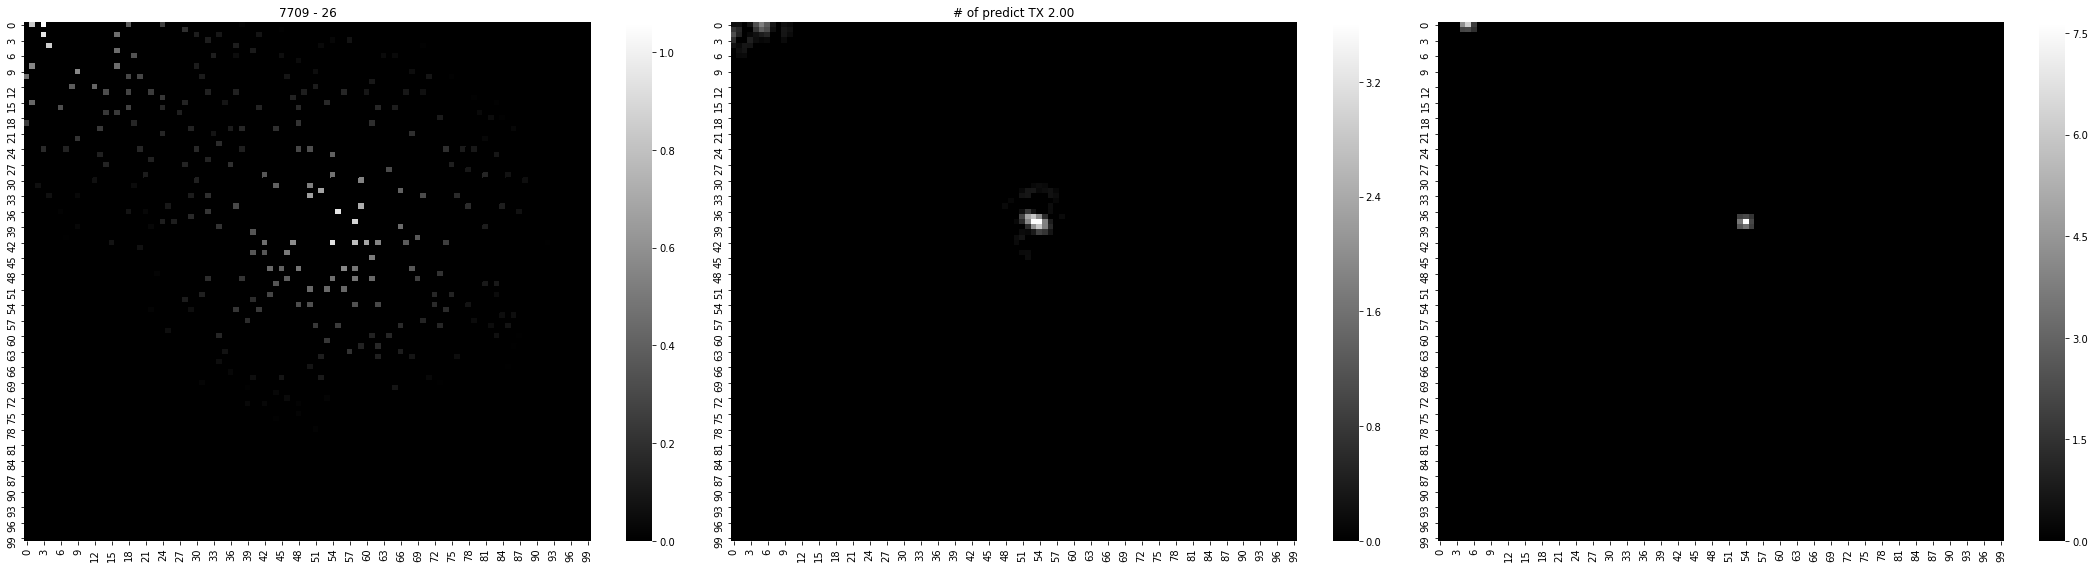

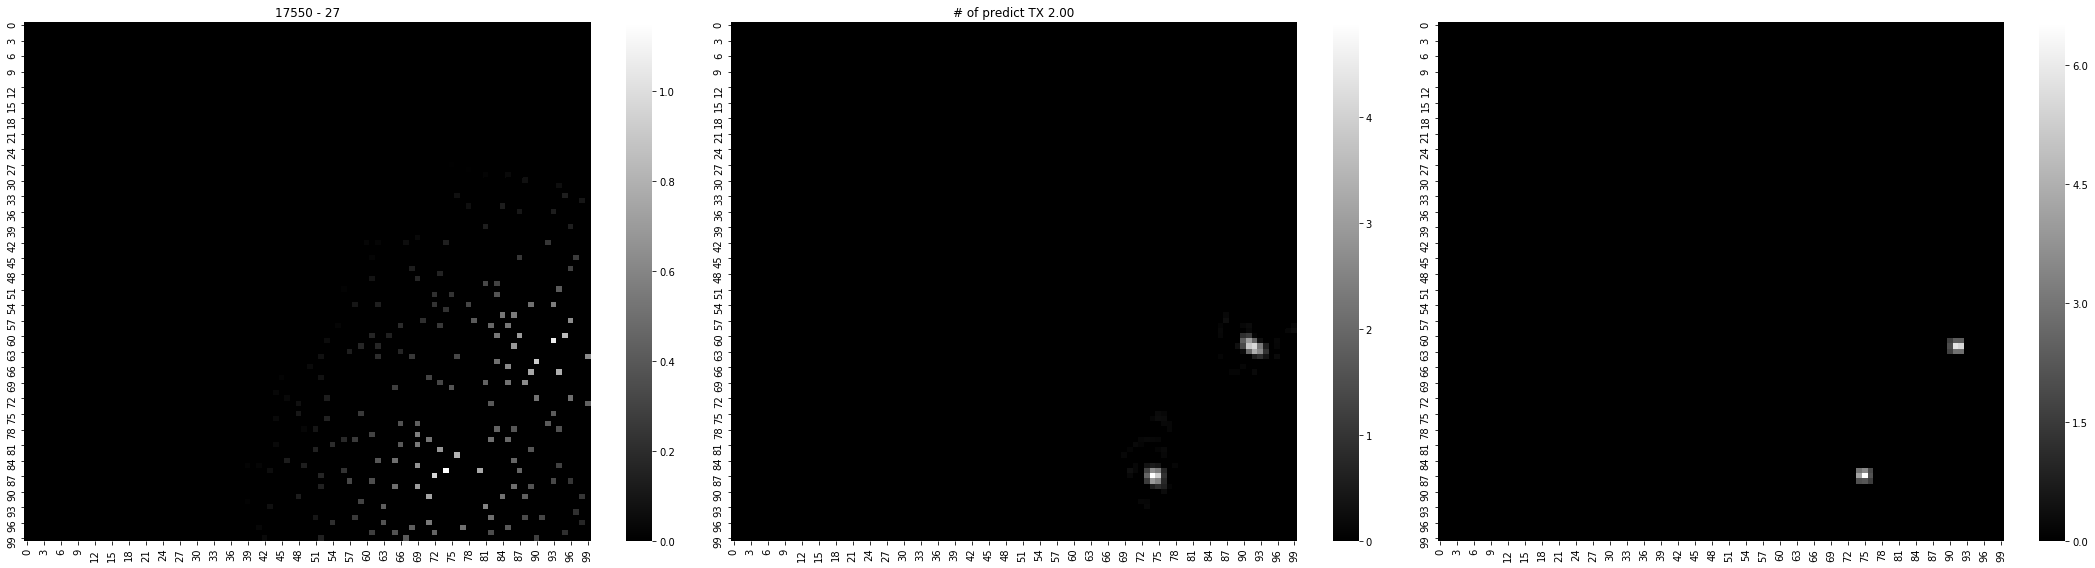

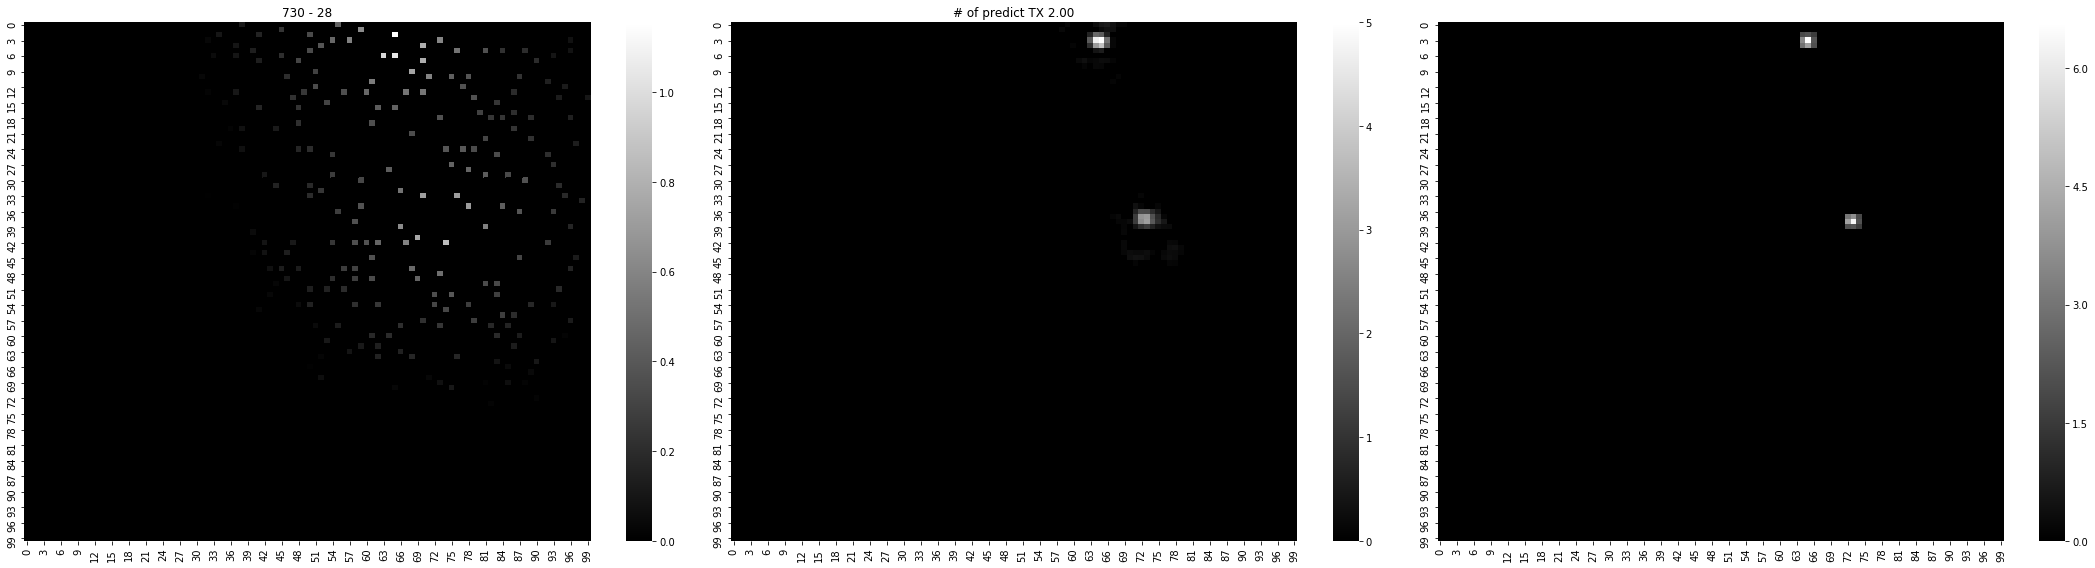

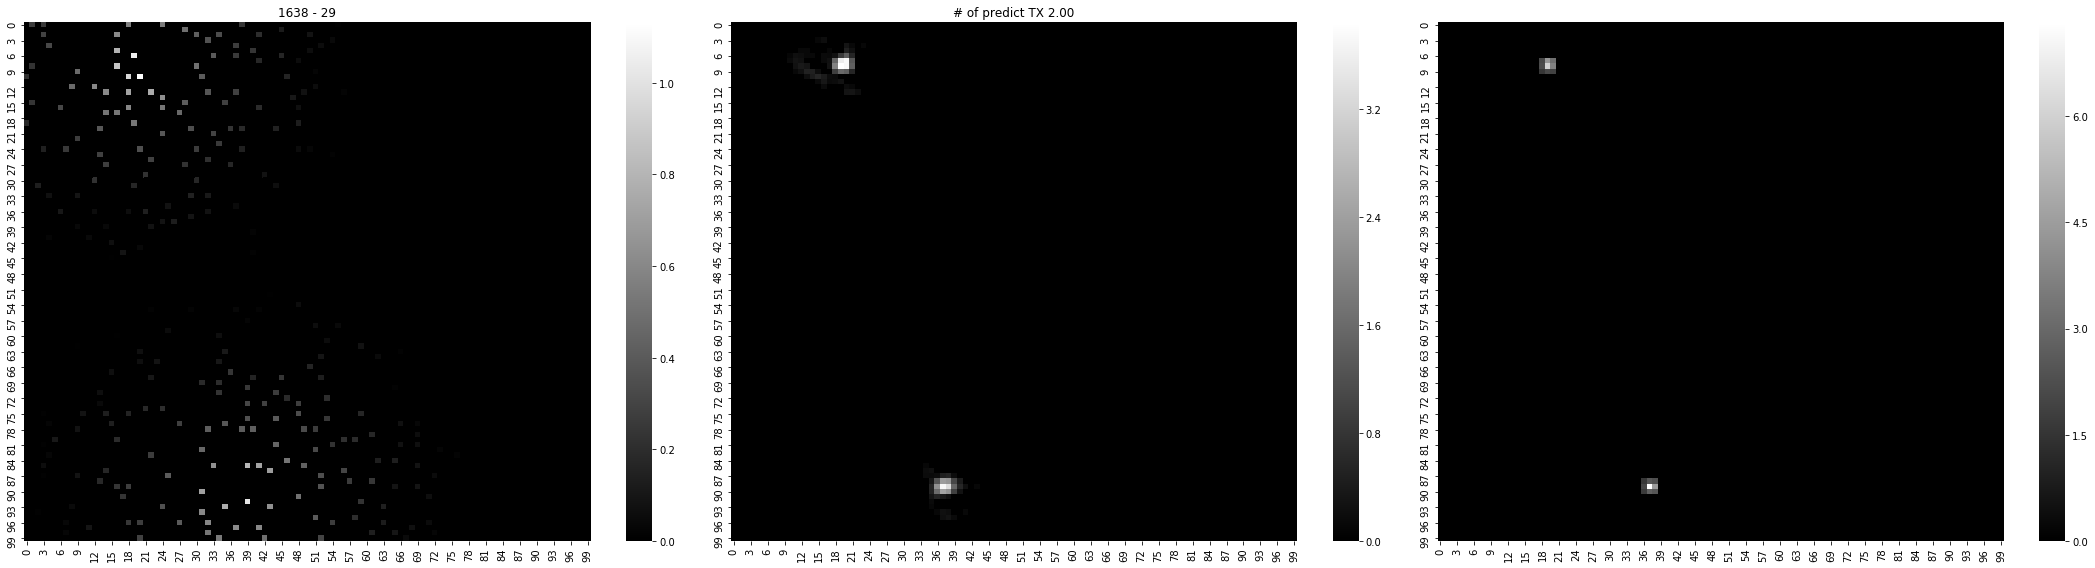

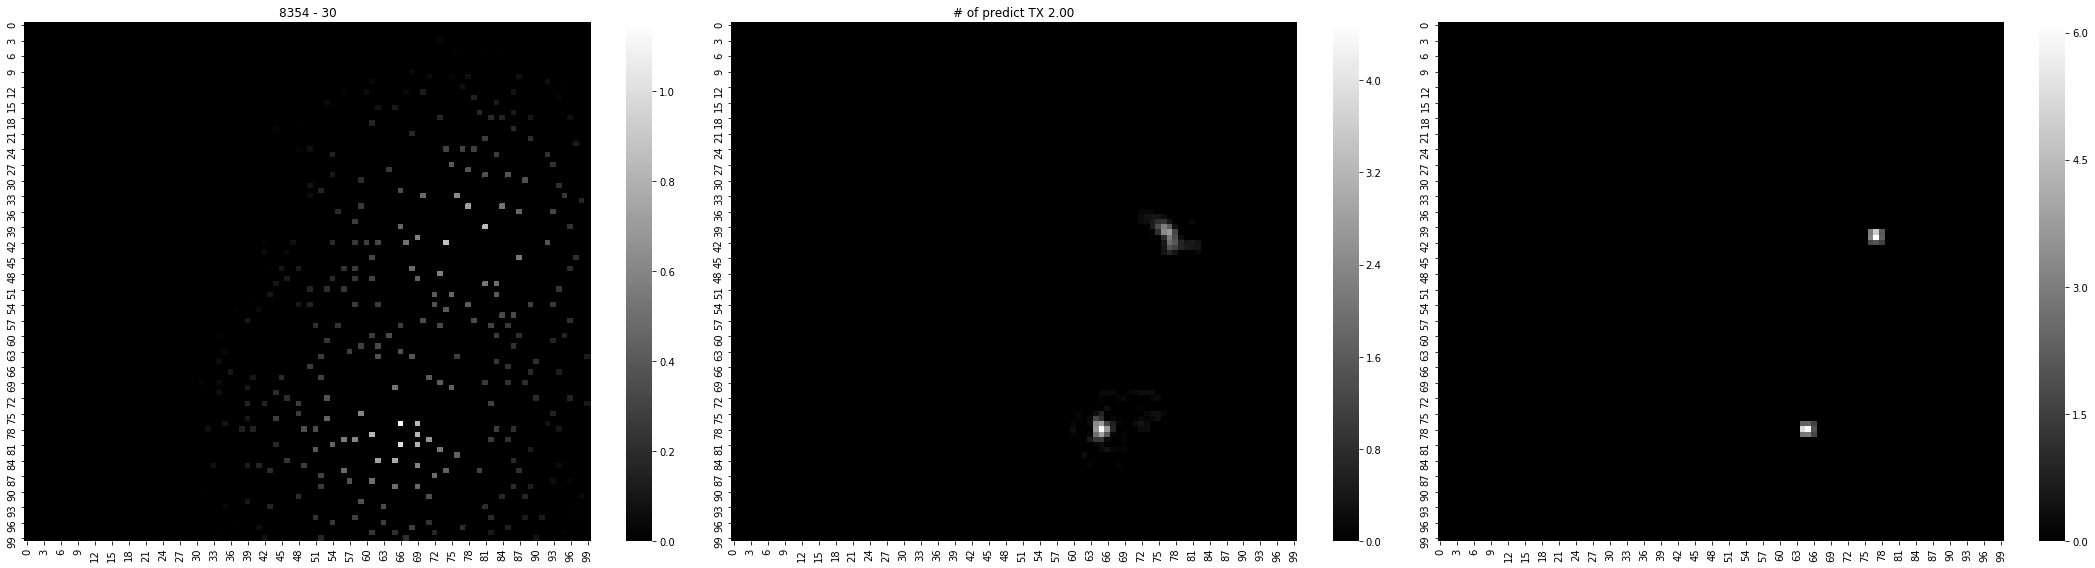

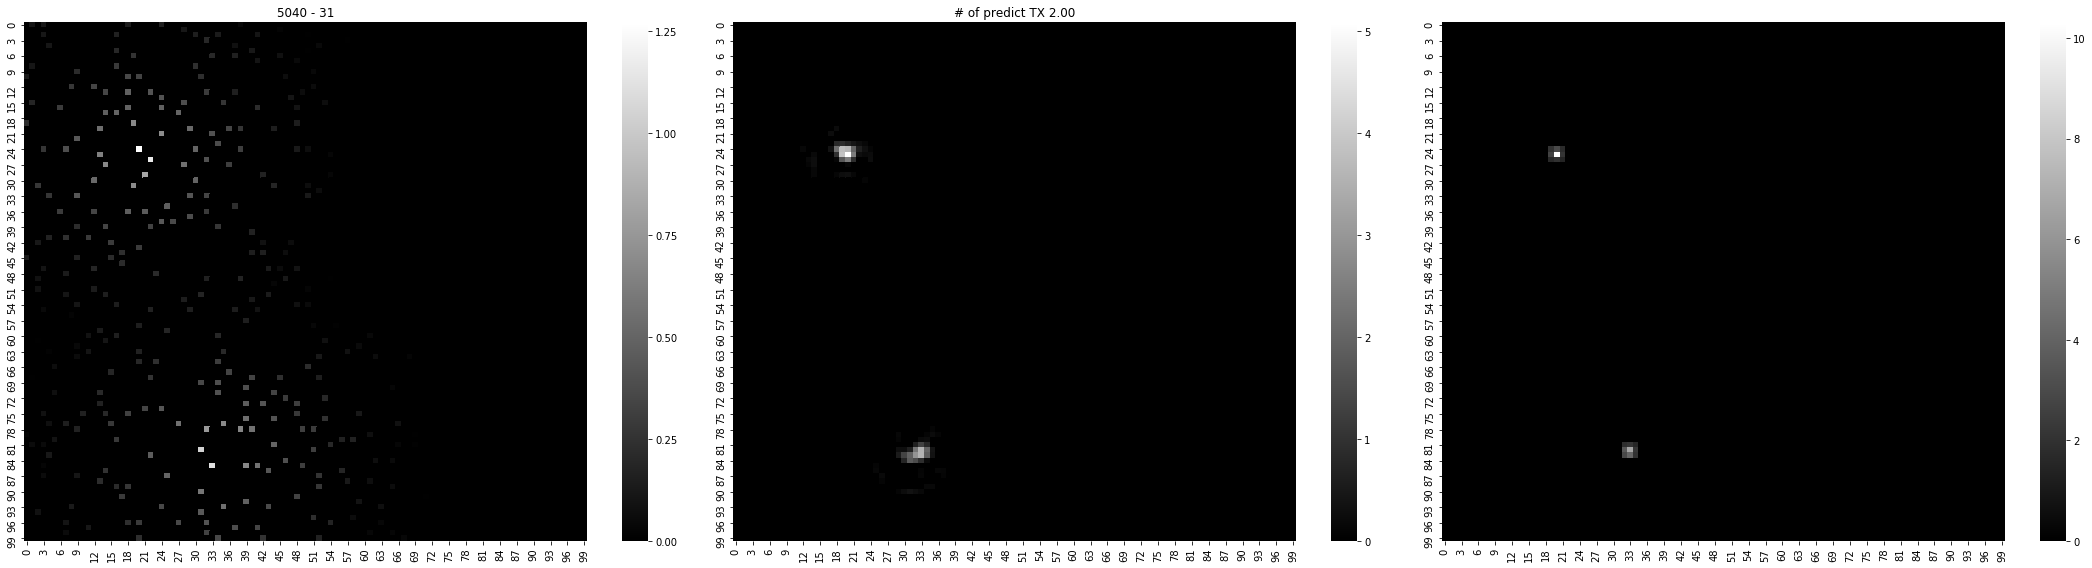

In [15]:
for i in range(len(pred_matrix)):
    myplot(X[i], pred_matrix[i], pred_ntx[i], y[i], indx[i], i)
    print(i, end=' ')

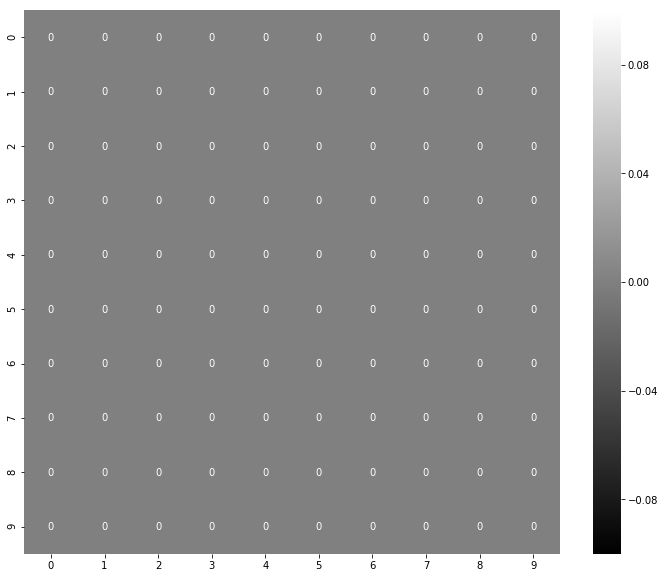

In [74]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pred_matrix[i, 0][:10,:10], cmap='gray', annot=True)

# Mics

In [42]:
for i in range(32):
    image = pred_matrix[i][0]
    threshold = 0.05
    peaks, size = Peaks.detect(image, 2)

    threshold_mask = image < threshold
    image[threshold_mask] = 0

    neighborhood = np.array([[True for _ in range(size)] for _ in range((size))])

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.
    #we create the mask of the background
    background = (image < 0.05)
    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    print(type(local_max), local_max.shape, type(eroded_background), eroded_background.shape)
    detected_peaks = local_max ^ eroded_background

    fig, axes = plt.subplots(1, 5, figsize=(25, 4.5))
    sns.heatmap(image, cmap='gray', annot=False, ax = axes[0])
    sns.heatmap(local_max, cmap='gray', annot=False, ax = axes[1])
    sns.heatmap(background, cmap='gray', annot=False, ax = axes[2])
    sns.heatmap(eroded_background, cmap='gray', annot=False, ax = axes[3])
    sns.heatmap(detected_peaks, cmap='gray', annot=False, ax = axes[4])
    axes[0].set_title('image {}'.format(i))
    axes[1].set_title('local max')
    axes[2].set_title('back ground')
    axes[3].set_title('eroded background')
    axes[4].set_title('peaks:{}, size:{}'.format(str(peaks), size))
    fig.tight_layout()

NameError: name 'Peaks' is not defined

In [77]:
# def detect(image, num_tx, threshold):
str(Peaks.detect(image, 2))

'[(33, 70), (49, 35)]'

In [11]:
indx = np.where(detected_peaks == True)

NameError: name 'detected_peaks' is not defined

In [60]:
x = indx[0]
y = indx[1]
for i, j in zip(x, y):
    print(i, j)

83 21
97 87


In [48]:
a = np.array([1, 2, 3, 4, 5])
np.where(a == 2)


(array([1]),)